In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import gym
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [6]:
class SumTree():
    #注意注意，所有的tree_idx都是指最后一层叶子的索引，没有出现过中间其他节点的索引的！
    
    '''https://blog.csdn.net/DeepOscar/article/details/80947155/
    很好的解释了类里面带object和不带object的区别。python3里面可以不带，因为带不带都默认带了
    是存储优先级和数据的树'''
    data_pointer = 0   #这就相当于self.data_pointer 是一个全局变量，这个是数据块data数据组的索引。
    
    def __init__(self, capacity):   #需要传入capacity这个形参，capacity是树的最底层叶子的总数！
        self.capacity = capacity
        self.tree = np.zeros(2 * capacity - 1)       #self.tree是用来存优先级p的树，只是存了优先级而已！
        #index: tree_idx ; data: p
        # [--------------Parent nodes-------------][-------leaves to recode priority-------]
        #             size: capacity - 1                       size: capacity
        self.data = np.zeros(capacity, dtype=object) #为什么创建数组的时候用dtype=object原因见下面的程序,[s,a,r,s_]放在这个data里面
        #index: data_ponter ; data: data
        # [--------------data frame-------------]
        #             size: capacity
    
    def add(self, p, data):
        '''添加p优先级和data到tree里面，当有新 sample 时, 添加进 tree 和 data'''
        #tree_idx是最后一行的叶子的索引。0+8-1=7，tree_idx可不是从0开始的！
        tree_idx = self.data_pointer + self.capacity - 1  #tree_idx是树最后一行节点的索引。和data_pointer的关系就是这样，建立tree的时候tree的idx是通过self.data_pointer计算出的
                                                          #为什么可以不出现self.data_pointer? 因为class下面直接定义了
        self.data[self.data_pointer] = data               #更新data，按照索引指针吧data存放在数组的对应位置
        
        self.update(tree_idx, p)                          #更新tree的框架,update函数在下面写了，需要参数tree_idx和优先级p
        
        self.data_pointer += 1                            #存完一个数据，存完一个叶子之后data_pointer+1.也就是说每次运行一下add，data_pointer+1
                                                          #每次运行add，就给tree的一个叶子赋值，并且往data里面存一个数据
                                                          #并且从tree的下边往上更新路径上的所有父节点
        if self.data_pointer >= self.capacity:            #当数据存满的时候从头开始更新数据
            self.data_pointer = 0 
    
    def update(self, tree_idx, p):
        '''更新树的每个节点的优先级p， 当 sample 被 train, 有了新的 TD-error, 就在 tree 中更新'''
        change = p - self.tree[tree_idx]  #优先级和目前的tree里面存放的优先级的差异
        self.tree[tree_idx] = p           #tree的tree_idx位置放上p
        
        #传播差异，自下往上更新所有父节点里面的p
        while tree_idx != 0:
            tree_idx = (tree_idx - 1)//2   #整除，得到整数,向下取整。如13-1=12 ，12/2=6. 6-1=5,5//2=2.每次计算都是父节点
            self.tree[tree_idx] += change  #从下往上更新这条路径上所有的节点！
            
    def get_leaf(self, v):
        """
        v就是从树的区间里随机取样出来的一个值。
        这里面阐述了怎么从最顶上的父节点选择路径找到叶子节点中的某个节点
        Tree structure and array storage:

        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for transitions

        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_idx = 0
        while True:  # the while loop is faster than the method in the reference code
            cl_idx = 2 * parent_idx + 1   # this leaf's left kids   某个节点的左侧的节点idx
            cr_idx = cl_idx + 1           # this leaf's right kids
            
            #!!!!!!!!这里是>=而不是>!!!
            if cl_idx >= len(self.tree):  #找到错误了！这里是>=而不是>
                leaf_idx = parent_idx     # reach bottom, end search
                break
            else:
#                 print('左节点idx',cl_idx)
#                 print('树长度',len(self.tree))
#                 print('父节点idx',parent_idx)
                if v <= self.tree[cl_idx]:
                    parent_idx = cl_idx    #如果左边的p比v大，就走左，下一步的parent_idx就变成左边的这个idx
                else:
                    v -= self.tree[cl_idx]
                    parent_idx = cr_idx    #变换父节点位置
        
        data_idx = leaf_idx - self.capacity + 1  #
        return leaf_idx, self.tree[leaf_idx], self.data[data_idx]  #返回了最终的叶子idx， 对应的p， data的idx对应的data
    
    #Python内置的@property装饰器就是负责把一个方法变成属性调用的
    @property
    def total_p(self):          #这个tree所有priority的总和，也就是最上面的叶子里面的数。
        return self.tree[0]   
        
        

# 在这里演示一下生成tree的工作过程

In [21]:
tree = SumTree(8)

In [22]:
tree.add(1, np.array([1,1,1,1]))
print(tree.tree)
print(tree.data)

[1. 1. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
[array([1, 1, 1, 1]) 0 0 0 0 0 0 0]


In [23]:
tree.add(2, np.array([2,2,2,2]))
print(tree.tree)
print(tree.data)

[3. 3. 0. 3. 0. 0. 0. 1. 2. 0. 0. 0. 0. 0. 0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) 0 0 0 0 0 0]


In [24]:
tree.add(3, np.array([3,3,3,3]))
print(tree.tree)
print(tree.data)

[6. 6. 0. 3. 3. 0. 0. 1. 2. 3. 0. 0. 0. 0. 0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3]) 0 0 0 0 0]


In [25]:
tree.add(4, np.array([4,4,4,4]))
print(tree.tree)
print(tree.data)

[10. 10.  0.  3.  7.  0.  0.  1.  2.  3.  4.  0.  0.  0.  0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) 0 0 0 0]


In [26]:
tree.add(1, np.array([5,5,5,5]))
print(tree.tree)
print(tree.data)

[11. 10.  1.  3.  7.  1.  0.  1.  2.  3.  4.  1.  0.  0.  0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) array([5, 5, 5, 5]) 0 0 0]


In [27]:
tree.add(3, np.array([6,6,6,6]))
print(tree.tree)
print(tree.data)

[14. 10.  4.  3.  7.  4.  0.  1.  2.  3.  4.  1.  3.  0.  0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) array([5, 5, 5, 5]) array([6, 6, 6, 6]) 0 0]


In [28]:
tree.add(2, np.array([7,7,7,7]))
print(tree.tree)
print(tree.data)

[16. 10.  6.  3.  7.  4.  2.  1.  2.  3.  4.  1.  3.  2.  0.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) array([5, 5, 5, 5]) array([6, 6, 6, 6])
 array([7, 7, 7, 7]) 0]


In [29]:
tree.add(5, np.array([8,8,8,8]))
print(tree.tree)
print(tree.data)

[21. 10. 11.  3.  7.  4.  7.  1.  2.  3.  4.  1.  3.  2.  5.]
[array([1, 1, 1, 1]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) array([5, 5, 5, 5]) array([6, 6, 6, 6])
 array([7, 7, 7, 7]) array([8, 8, 8, 8])]


# 存满再存会把最下面一行的第一个替换掉

In [13]:
tree.add(6, np.array([8,8,8,8]))
print(tree.tree)
print(tree.data)

[26. 15. 11.  8.  7.  4.  7.  6.  2.  3.  4.  1.  3.  2.  5.]
[array([8, 8, 8, 8]) array([2, 2, 2, 2]) array([3, 3, 3, 3])
 array([4, 4, 4, 4]) array([5, 5, 5, 5]) array([6, 6, 6, 6])
 array([7, 7, 7, 7]) array([8, 8, 8, 8])]


# 演示一下sample时调用get_leaf的过程，上面树的capacity是8，我取出6个data

In [30]:
#用empty产生随机的值
#树叶子的idx， 一批data的memory， ISWeights                            #这个是每个transition的长度
b_idx, b_memory, ISWeights = np.empty((6,),dtype=np.int32), np.empty((6,tree.data[0].size)), np.empty((6,1))
print(b_idx)
print(b_memory)
print(ISWeights)

[16843009 16843009 16843009 16843009 16843009 16843009]
[[8. 8. 8. 8.]
 [2. 2. 2. 2.]
 [3. 3. 3. 3.]
 [5. 5. 5. 5.]
 [7. 7. 7. 7.]
 [8. 8. 8. 8.]]
[[0.4874851 ]
 [0.75733316]
 [0.64368646]
 [1.        ]
 [0.75733316]
 [0.52446079]]


In [31]:
ISWeights[1,0]

0.7573331579384879

In [32]:
print(tree.data[0])
print(tree.data[0].size)
epsilon = 0.01  # small amount to avoid zero priority
alpha = 0.6  # [0~1] convert the importance of TD error to priority
beta = 0.4  # importance-sampling, from initial value increasing to 1
beta_increment_per_sampling = 0.001
abs_err_upper = 1.  # clipped abs error

[1 1 1 1]
4


In [33]:
print(tree.tree[0])
pri_seg = tree.tree[0] / 6    # 把totlep分段分成六段。
print(pri_seg)
beta = np.min([1., beta + beta_increment_per_sampling])

min_prob = np.min(tree.tree[-8:])/tree.tree[0]
print(tree.tree[-8:])
print(np.min(tree.tree[-8:]))
print(min_prob)

21.0
3.5
[1. 2. 3. 4. 1. 3. 2. 5.]
1.0
0.047619047619047616


In [34]:
for i in range(6):
    print('第{}次选择'.format(i))
    a, b = pri_seg * i, pri_seg * (i+1)
    print('段上下限',a,b)
    v = np.random.uniform(a,b)
    print('v is:',v)
    idx, p, data = tree.get_leaf(v)
    print('the leaf_idx is :',idx)
    print('the priority is :',p)
    print('the data chosed is :',data)
    prob = p/tree.tree[0]
    ISWeights[i,0] = np.power(prob/min_prob, -beta) # (prob/min_prob)^(-beta)
    b_idx[i], b_memory[i, :] = idx, data
    
    
print(b_idx)
print(b_memory)
print(ISWeights)

第0次选择
段上下限 0.0 3.5
v is: 2.9912735197547264
the leaf_idx is : 8
the priority is : 2.0
the data chosed is : [2 2 2 2]
第1次选择
段上下限 3.5 7.0
v is: 4.322240033425614
the leaf_idx is : 9
the priority is : 3.0
the data chosed is : [3 3 3 3]
第2次选择
段上下限 7.0 10.5
v is: 9.505420496044142
the leaf_idx is : 10
the priority is : 4.0
the data chosed is : [4 4 4 4]
第3次选择
段上下限 10.5 14.0
v is: 12.36824995590315
the leaf_idx is : 12
the priority is : 3.0
the data chosed is : [6 6 6 6]
第4次选择
段上下限 14.0 17.5
v is: 14.842229658597315
the leaf_idx is : 13
the priority is : 2.0
the data chosed is : [7 7 7 7]
第5次选择
段上下限 17.5 21.0
v is: 18.257073551661215
the leaf_idx is : 14
the priority is : 5.0
the data chosed is : [8 8 8 8]
[ 8  9 10 12 13 14]
[[2. 2. 2. 2.]
 [3. 3. 3. 3.]
 [4. 4. 4. 4.]
 [6. 6. 6. 6.]
 [7. 7. 7. 7.]
 [8. 8. 8. 8.]]
[[0.75733316]
 [0.64368646]
 [0.57355351]
 [0.64368646]
 [0.75733316]
 [0.52446079]]


In [7]:
class Memory(): # stored as ( s, a, r, s_ ) in SumTree
    '''memory模块，包含了怎么sample的，怎么strore的，怎么整批利用error更新树的'''
    epsilon = 0.01  # small amount to avoid zero priority
    alpha = 0.6  # [0~1] convert the importance of TD error to priority
    beta = 0.4  # importance-sampling, from initial value increasing to 1
    beta_increment_per_sampling = 0.001
    abs_err_upper = 1.  # clipped abs error
    
    def __init__(self, capacity):
        self.tree = SumTree(capacity)
    
    #这个函数不再learn里面，每一步都会运行这个
    def store(self, transition):#把所有最底层叶子里的最大值存入叶子中。并且存储一个transition
        #在没有learn之前，就是把最底层的所有叶子都放入1.
        '''transition就是一个[s,a,r,s_],每次存一个,这个不在learn函数里，每一步都存'''
        max_p = np.max(self.tree.tree[-self.tree.capacity:])  #这是tree的最下面一行的所有叶子的p值，因为tree的长度是2*capacity-1,最后一行刚好是这个索引
        if max_p==0:
            max_p = self.abs_err_upper
#         print(max_p)
        self.tree.add(max_p, transition)   #利用add函数把p存进tree里，把transition存到data里
    
    #下面的两个方法都是在learn函数中。
    def sample(self,n):
        '''从memory里面采样出n个transition来作为训练的数据'''
        b_idx, b_memory, ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, self.tree.data[0].size)), np.empty((n, 1))
        pri_seg = self.tree.total_p / n       # priority segment
        self.beta = np.min([1., self.beta + self.beta_increment_per_sampling])  # max = 1

        min_prob = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_p     # for later calculate ISweight
        for i in range(n):
            a, b = pri_seg * i, pri_seg * (i + 1)
            v = np.random.uniform(a, b)
            idx, p, data = self.tree.get_leaf(v)
            prob = p / self.tree.total_p
            ISWeights[i, 0] = np.power(prob/min_prob, -self.beta)
            b_idx[i], b_memory[i, :] = idx, data
        return b_idx, b_memory, ISWeights
    
    def batch_update(self, tree_idx, abs_errors):  #这个才是真正的把TD-error存入树的函数！在learn的时候存入的，把挑选出的最下面一层叶子索引对应的干路更新、
        abs_errors += self.epsilon   #避免errors为0
        clipped_errors = np.minimum(abs_errors, self.abs_err_upper)  #选择两者的最小值，保证error最大为1.0
        ps = np.power(clipped_errors, self.alpha)
        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
            

In [8]:
class DeepQNetwork:
    def __init__(
        self,
        n_actions,
        n_features,
        learning_rate=0.005,
        reward_decay=0.9,
        e_greedy = 0.9,
        replace_target_iter=500,
        memory_size=10000,
        batch_size=32,
        e_greedy_increment=None, #这个是设置epsilon的变化与否的，它是nan证明epsilon一直不变
        output_graph=False,
        
        #这里加上priority选项
        #-----------------------------------------------------------------------------------------------------------------
        prioritized=True
        #------------------------------------------------------------------------------------------------------------------
    ):
        '''动作数量，状态数量'''
        self.n_actions = n_actions
        self.n_features = n_features
        self.lr = learning_rate
        self.gamma = reward_decay
        self.epsilon_max = e_greedy
        self.replace_target_iter = replace_target_iter
        self.memory_size = memory_size
        self.batch_size = batch_size
        self.epsilon_increment = e_greedy_increment
        #如果e_greedy_increment不是none，那么刚开始动作是瞎选的，随着learn的次数增多
        #epsilon值慢慢增加，每次增加e_greedy_increment直到最大，使得随机选动作的概率变小
        self.epsilon = 0 if e_greedy_increment is not None else self.epsilon_max
        
        #-----------------------------------------------------------------------------------------------------------------
        self.prioritized = prioritized
        #------------------------------------------------------------------------------------------------------------------
        
        # 总共的学习步数，执行一次learn函数，这个值才加一
        self.learn_step_counter = 0
        
        # 初始化[s, a, r, s_],可以选择是否用priority产生memory
        #-----------------------------------------------------------------------------------------------------------------
        if self.prioritized:
            self.memory = Memory(capacity=memory_size)
        else:
            self.memory = np.zeros((self.memory_size, n_features*2 + 2))  #两个s的长度加上2（1个reward，一个action）
        #-----------------------------------------------------------------------------------------------------------------
        
        # [target_net, evalunet]
        self._build_net()   #因为self.target_net和self.evalunet这两个网络是在这个方法里产生的，别的方法要去调用他们，
        #要么这两个网络在别的方法里先被运行出来，就可以被调用了
        #要么这两个网络一开始就变成全局的变量，不用别的方法每次都运行一遍。！
        
        self.cost_his = []     #这一句是创造一个记录损失的列表
        
    def _build_net(self):
        '''建立预测模型和target模型,这里要用到ISWeights，sample计算出的ISWeights要用到网络中进行训练'''
        #----------------------------------build evaluate model--------------------------------
        # 输入状态，None,2 ;输出动作对应的值 None,4 四个动作每个都对应一个动作价值
        s = tf.keras.layers.Input(shape=(self.n_features,), name='s')
        q_target = tf.keras.layers.Input(shape=(self.n_actions,), name='q_target')
        
        #-----------------------------------------------------------------------------------------------------------------
        #如果要用优先级，那么要把ISWeights引入，它的性质，和q_target一样，就是用于训练loss计算用的，用不用Input都行
        if self.prioritized:
            ISWeights = tf.keras.layers.Input(shape=(1,), name='ISWeights')
        #-----------------------------------------------------------------------------------------------------------------
        
        # 预测模型，和原来没区别
        x = tf.keras.layers.Dense(20, activation='relu', name='l1')(s)
        x = tf.keras.layers.Dense(self.n_actions, name='l2')(x)
        self.eval_net = tf.keras.Model(inputs=s, outputs=x)
        
        
        #损失函数,和tf1.不一样，2.是先定义损失函数，再去在后面使用,缺少一个abs_errors，直接在后面预算，不必在此定义了，
        #在这里定义损失函数只不过是为了简便罢了,关于loss的变化，我会在后面learn里面直接加上
        self.loss = tf.keras.losses.MeanSquaredError() #等同于tf.reduce_mean(tf.squared_difference(self.q_target, self.q_eval))
        
        #优化器
        self._train_op = tf.keras.optimizers.RMSprop(learning_rate=self.lr)
        
        #-----------------------------------build target model------------------------------------
        #目标模型就是一个框架，他不需要训练，只需要把预测模型里面的权重往里更新即可
        s_ = tf.keras.layers.Input(shape=(self.n_features,), name='s_')
        
        #目标模型
        x = tf.keras.layers.Dense(20, activation='relu', name='l1')(s_)
        x = tf.keras.layers.Dense(self.n_actions, name='l2')(x)
        self.target_net = tf.keras.Model(inputs=s_, outputs=x)
        
    def replace_target(self): #是tf2.里面特有的函数，为了复制权重用的
        '''预测模型的权重更新到目标模型'''
        #使用set_weights和get_weights的方法对每层的权重进行复制转移
        self.target_net.get_layer(name='l1').set_weights(self.eval_net.get_layer(name='l1').get_weights())
        self.target_net.get_layer(name='l2').set_weights(self.eval_net.get_layer(name='l2').get_weights())
        
    def store_transition(self, s, a, r, s_):  #这里传入的a是一个动作！
        '''存入记忆库'''
        
        #-----------------------------------------------------------------------------------------------------------------
        # 这里也要加入是否要用priority的方法存储记忆
        if self.prioritized: #采用Memory类里的方法存储记忆，也就是priority方法
            transition = np.hstack((s, [a,r], s_))
            self.memory.store(transition)
            #看看没有更新之前的memory里面的tree的叶子到底什么样
#             print(self.memory.tree.tree[-self.memory_size:])
            
        else:               #采用传统方法存储记忆
            if not hasattr(self, 'memory_counter'):
            #返回对象是否具有具有给定名称的属性。从上面来看，是没有的，那么hasattr会返回FALSE，也就是说如果没有，就会执行下面语句
                self.memory_counter = 0
            transition = np.hstack((s, [a,r], s_))
        
            # 替换旧的memory，当memory计数500次，下一次就会更新memory的第一行，。。。
            index = self.memory_counter % self.memory_size  #取余
            self.memory[index, :] = transition

            self.memory_counter += 1
        #-----------------------------------------------------------------------------------------------------------------
        
    
    def choose_action(self, observation):
        '''选择动作的方法'''
        observation = observation[np.newaxis, :]  
        #在s前面增加一个维度，如s原来是[2,]现在变成[1,2]，因为要这样才能符合模型的要求，因为模型要求[None,2]和RNN北京天气讲的单个预测方法一样
        
        # 小于epsilon时候按照动作价值选,用模型预测出四个动作价值，转成numpy之后用最大索引
        if np.random.uniform() < self.epsilon:
            actions_value = self.eval_net(observation).numpy()
            action = np.argmax(actions_value)
        else:
            action = np.random.randint(0, self.n_actions)
        
        return action
    
    def learn(self):
        '''从记忆库学习'''
        print('learn step is:',self.learn_step_counter)
        if self.learn_step_counter % self.replace_target_iter == 0: 
            #每replace_target次学习更换一次参数,也就是把target模型的参数更新成和evaluate模型参数
            self.replace_target()
            print('\n目标模型的参数已经被替换。')
            
        # 从memory里面采样，采样当然也要加上priority的选择了！
        #-----------------------------------------------------------------------------------------------------------------
        if self.prioritized:
            #tree_idx是sample出来的那32个最后一行的叶子索引
            tree_idx, batch_memory, ISWeights = self.memory.sample(self.batch_size)

        else:
            if self.memory_counter > self.memory_size:
            #如果memory存储次数大于了memory表的长度（500）
                sample_index = np.random.choice(self.memory_size, size=self.batch_size)  #从500里面选择32个整数作为索引
            else:
            #会不会出现memorycounter<32的情况，首先让memory记录多少，这是在主循环里面设定的
                sample_index = np.random.choice(self.memory_counter, size=self.batch_size) #从memorycounter范围选取32个整数作为索引
        
            batch_memory = self.memory[sample_index, :]  #从memory表里面取出上面32个索引对应的行作为batchmemory
        #-----------------------------------------------------------------------------------------------------------------
        
        
        with tf.GradientTape() as tape:
            # batch_memory一共32行，6列，前2列s,action1列，r1列，最后两列s_.所以是把s_放到target网络里面，得到q_next[32,4],一个q表
            
            #生成之前的结果，是以前的模型生成的，是一个[32,4]的tensor
            q_next = self.target_net(batch_memory[:, -self.n_features:]).numpy() #模型输入：所有行，最后两列s_。q_target随便，因为它不用训练
            
            #生成预测结果，是现在的模型生成的, 是一个[32,4]的tensor
            q_eval = self.eval_net(batch_memory[:, :self.n_features])      #这里不能直接.numpy()，因为会使他不是tensor，造成无法计算梯度
            #模型输入：所有行，前两列s
            
            #改变q_target,q_target[32,4]
            q_target = q_eval.numpy()
            batch_index = np.arange(self.batch_size, dtype=np.int32)       #0到31
            eval_act_index = batch_memory[:, self.n_features].astype(int)  #预测的动作:所有行，index=2也就是第三列.[32,]
            reward = batch_memory[:, self.n_features+1]                    #奖励，index=3也就是第4列,[32,]
            
            #根据奖励更新当前的预测结果:这里怎么选的？ 每行按照动作index选一个，最后形状是[32,]，对负数的动作如-3也可以选，就是往左数，
            #不够用了再蹦到右边往左数
            q_target[batch_index, eval_act_index]  = reward + self.gamma * np.max(q_next, axis=1) #左右最大，也就是这一行的最大值
            
            
            #计算损失也要加入priority的选项！！！
            #-----------------------------------------------------------------------------------------------------------------
            #计算损失
            if self.prioritized:
                #计算TD-error
                abs_errors = tf.reduce_sum(tf.abs(q_target - q_eval), axis=1)
                #计算cost
#                 self.cost = ISWeights * self.loss(y_true=q_target, y_pred=q_eval)  #有改动，这个提出来有影响我擦，这个ISWeights是有形状的，
                #所以要是这么乘，出来也有形状，[32,1]这样不但优化慢，还画不出图，要改！
                #注意，很多tf的数学函数更新之后都放在math模块里了！这个方差函数出来是有形状的，刚好可以和ISWeights作点乘*。对应相乘最后形状还是
                #[32,].tensorflow里的矩阵乘法是matmul
                self.cost = tf.reduce_mean(ISWeights * tf.math.squared_difference(q_target, q_eval))
                
                #更新树的优先值p，更新优选出来的32个最下面一层叶子对应主干的所有p
                self.memory.batch_update(tree_idx, abs_errors)
            else:
                self.cost = self.loss(y_true=q_target, y_pred=q_eval)
            #-----------------------------------------------------------------------------------------------------------------
            
            
        #计算梯度
        gradients = tape.gradient(self.cost, self.eval_net.trainable_variables)
        #优化器梯度下降
        self._train_op.apply_gradients(zip(gradients, self.eval_net.trainable_variables))
        #记录损失
        self.cost_his.append(self.cost)
        
        # increasing epsilon
        # 随机概率随着训练次数减少，默认不变
        self.epsilon = self.epsilon + self.epsilon_increment if self.epsilon < self.epsilon_max else self.epsilon_max
        self.learn_step_counter += 1  #只要执行一次learn函数，这个就会加一
    
    def plot_cost(self):
        plt.plot(np.arange(len(self.cost_his)), self.cost_his)
        plt.ylabel('cost')
        plt.xlabel('steps')
        plt.show()

In [9]:
env = gym.make('MountainCar-v0')
env = env.unwrapped
env.seed(21)
MEMORY_SIZE = 10000

# 这个是使用了priority的DQN的结果

In [6]:
RL = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=env.observation_space.shape[0],
                  memory_size=MEMORY_SIZE,
                  e_greedy_increment=0.0005,
                  prioritized=True)

learn step is: 0

目标模型的参数已经被替换。

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Laye

learn step is: 365
learn step is: 366
learn step is: 367
learn step is: 368
learn step is: 369
learn step is: 370
learn step is: 371
learn step is: 372
learn step is: 373
learn step is: 374
learn step is: 375
learn step is: 376
learn step is: 377
learn step is: 378
learn step is: 379
learn step is: 380
learn step is: 381
learn step is: 382
learn step is: 383
learn step is: 384
learn step is: 385
learn step is: 386
learn step is: 387
learn step is: 388
learn step is: 389
learn step is: 390
learn step is: 391
learn step is: 392
learn step is: 393
learn step is: 394
learn step is: 395
learn step is: 396
learn step is: 397
learn step is: 398
learn step is: 399
learn step is: 400
learn step is: 401
learn step is: 402
learn step is: 403
learn step is: 404
learn step is: 405
learn step is: 406
learn step is: 407
learn step is: 408
learn step is: 409
learn step is: 410
learn step is: 411
learn step is: 412
learn step is: 413
learn step is: 414
learn step is: 415
learn step is: 416
learn step i

learn step is: 1215
learn step is: 1216
learn step is: 1217
learn step is: 1218
learn step is: 1219
learn step is: 1220
learn step is: 1221
learn step is: 1222
learn step is: 1223
learn step is: 1224
learn step is: 1225
learn step is: 1226
learn step is: 1227
learn step is: 1228
learn step is: 1229
learn step is: 1230
learn step is: 1231
learn step is: 1232
learn step is: 1233
learn step is: 1234
learn step is: 1235
learn step is: 1236
learn step is: 1237
learn step is: 1238
learn step is: 1239
learn step is: 1240
learn step is: 1241
learn step is: 1242
learn step is: 1243
learn step is: 1244
learn step is: 1245
learn step is: 1246
learn step is: 1247
learn step is: 1248
learn step is: 1249
learn step is: 1250
learn step is: 1251
learn step is: 1252
learn step is: 1253
learn step is: 1254
learn step is: 1255
learn step is: 1256
learn step is: 1257
learn step is: 1258
learn step is: 1259
learn step is: 1260
learn step is: 1261
learn step is: 1262
learn step is: 1263
learn step is: 1264


learn step is: 1630
learn step is: 1631
learn step is: 1632
learn step is: 1633
learn step is: 1634
learn step is: 1635
learn step is: 1636
learn step is: 1637
learn step is: 1638
learn step is: 1639
learn step is: 1640
learn step is: 1641
learn step is: 1642
learn step is: 1643
learn step is: 1644
learn step is: 1645
learn step is: 1646
learn step is: 1647
learn step is: 1648
learn step is: 1649
learn step is: 1650
learn step is: 1651
learn step is: 1652
learn step is: 1653
learn step is: 1654
learn step is: 1655
learn step is: 1656
learn step is: 1657
learn step is: 1658
learn step is: 1659
learn step is: 1660
learn step is: 1661
learn step is: 1662
learn step is: 1663
learn step is: 1664
learn step is: 1665
learn step is: 1666
learn step is: 1667
learn step is: 1668
learn step is: 1669
learn step is: 1670
learn step is: 1671
learn step is: 1672
learn step is: 1673
learn step is: 1674
learn step is: 1675
learn step is: 1676
learn step is: 1677
learn step is: 1678
learn step is: 1679


learn step is: 2040
learn step is: 2041
learn step is: 2042
learn step is: 2043
learn step is: 2044
learn step is: 2045
learn step is: 2046
learn step is: 2047
learn step is: 2048
learn step is: 2049
learn step is: 2050
learn step is: 2051
learn step is: 2052
learn step is: 2053
learn step is: 2054
learn step is: 2055
learn step is: 2056
learn step is: 2057
learn step is: 2058
learn step is: 2059
learn step is: 2060
learn step is: 2061
learn step is: 2062
learn step is: 2063
learn step is: 2064
learn step is: 2065
learn step is: 2066
learn step is: 2067
learn step is: 2068
learn step is: 2069
learn step is: 2070
learn step is: 2071
learn step is: 2072
learn step is: 2073
learn step is: 2074
learn step is: 2075
learn step is: 2076
learn step is: 2077
learn step is: 2078
learn step is: 2079
learn step is: 2080
learn step is: 2081
learn step is: 2082
learn step is: 2083
learn step is: 2084
learn step is: 2085
learn step is: 2086
learn step is: 2087
learn step is: 2088
learn step is: 2089


learn step is: 2454
learn step is: 2455
learn step is: 2456
learn step is: 2457
learn step is: 2458
learn step is: 2459
learn step is: 2460
learn step is: 2461
learn step is: 2462
learn step is: 2463
learn step is: 2464
learn step is: 2465
learn step is: 2466
learn step is: 2467
learn step is: 2468
learn step is: 2469
learn step is: 2470
learn step is: 2471
learn step is: 2472
learn step is: 2473
learn step is: 2474
learn step is: 2475
learn step is: 2476
learn step is: 2477
learn step is: 2478
learn step is: 2479
learn step is: 2480
learn step is: 2481
learn step is: 2482
learn step is: 2483
learn step is: 2484
learn step is: 2485
learn step is: 2486
learn step is: 2487
learn step is: 2488
learn step is: 2489
learn step is: 2490
learn step is: 2491
learn step is: 2492
learn step is: 2493
learn step is: 2494
learn step is: 2495
learn step is: 2496
learn step is: 2497
learn step is: 2498
learn step is: 2499
learn step is: 2500

目标模型的参数已经被替换。
learn step is: 2501
learn step is: 2502
learn

learn step is: 2861
learn step is: 2862
learn step is: 2863
learn step is: 2864
learn step is: 2865
learn step is: 2866
learn step is: 2867
learn step is: 2868
learn step is: 2869
learn step is: 2870
learn step is: 2871
learn step is: 2872
learn step is: 2873
learn step is: 2874
learn step is: 2875
learn step is: 2876
learn step is: 2877
learn step is: 2878
learn step is: 2879
learn step is: 2880
learn step is: 2881
learn step is: 2882
learn step is: 2883
learn step is: 2884
learn step is: 2885
learn step is: 2886
learn step is: 2887
learn step is: 2888
learn step is: 2889
learn step is: 2890
learn step is: 2891
learn step is: 2892
learn step is: 2893
learn step is: 2894
learn step is: 2895
learn step is: 2896
learn step is: 2897
learn step is: 2898
learn step is: 2899
learn step is: 2900
learn step is: 2901
learn step is: 2902
learn step is: 2903
learn step is: 2904
learn step is: 2905
learn step is: 2906
learn step is: 2907
learn step is: 2908
learn step is: 2909
learn step is: 2910


learn step is: 3270
learn step is: 3271
learn step is: 3272
learn step is: 3273
learn step is: 3274
learn step is: 3275
learn step is: 3276
learn step is: 3277
learn step is: 3278
learn step is: 3279
learn step is: 3280
learn step is: 3281
learn step is: 3282
learn step is: 3283
learn step is: 3284
learn step is: 3285
learn step is: 3286
learn step is: 3287
learn step is: 3288
learn step is: 3289
learn step is: 3290
learn step is: 3291
learn step is: 3292
learn step is: 3293
learn step is: 3294
learn step is: 3295
learn step is: 3296
learn step is: 3297
learn step is: 3298
learn step is: 3299
learn step is: 3300
learn step is: 3301
learn step is: 3302
learn step is: 3303
learn step is: 3304
learn step is: 3305
learn step is: 3306
learn step is: 3307
learn step is: 3308
learn step is: 3309
learn step is: 3310
learn step is: 3311
learn step is: 3312
learn step is: 3313
learn step is: 3314
learn step is: 3315
learn step is: 3316
learn step is: 3317
learn step is: 3318
learn step is: 3319


learn step is: 3679
learn step is: 3680
learn step is: 3681
learn step is: 3682
learn step is: 3683
learn step is: 3684
learn step is: 3685
learn step is: 3686
learn step is: 3687
learn step is: 3688
learn step is: 3689
learn step is: 3690
learn step is: 3691
learn step is: 3692
learn step is: 3693
learn step is: 3694
learn step is: 3695
learn step is: 3696
learn step is: 3697
learn step is: 3698
learn step is: 3699
learn step is: 3700
learn step is: 3701
learn step is: 3702
learn step is: 3703
learn step is: 3704
learn step is: 3705
learn step is: 3706
learn step is: 3707
learn step is: 3708
learn step is: 3709
learn step is: 3710
learn step is: 3711
learn step is: 3712
learn step is: 3713
learn step is: 3714
learn step is: 3715
learn step is: 3716
learn step is: 3717
learn step is: 3718
learn step is: 3719
learn step is: 3720
learn step is: 3721
learn step is: 3722
learn step is: 3723
learn step is: 3724
learn step is: 3725
learn step is: 3726
learn step is: 3727
learn step is: 3728


learn step is: 4099
learn step is: 4100
learn step is: 4101
learn step is: 4102
learn step is: 4103
learn step is: 4104
learn step is: 4105
learn step is: 4106
learn step is: 4107
learn step is: 4108
learn step is: 4109
learn step is: 4110
learn step is: 4111
learn step is: 4112
learn step is: 4113
learn step is: 4114
learn step is: 4115
learn step is: 4116
learn step is: 4117
learn step is: 4118
learn step is: 4119
learn step is: 4120
learn step is: 4121
learn step is: 4122
learn step is: 4123
learn step is: 4124
learn step is: 4125
learn step is: 4126
learn step is: 4127
learn step is: 4128
learn step is: 4129
learn step is: 4130
learn step is: 4131
learn step is: 4132
learn step is: 4133
learn step is: 4134
learn step is: 4135
learn step is: 4136
learn step is: 4137
learn step is: 4138
learn step is: 4139
learn step is: 4140
learn step is: 4141
learn step is: 4142
learn step is: 4143
learn step is: 4144
learn step is: 4145
learn step is: 4146
learn step is: 4147
learn step is: 4148


learn step is: 4510
learn step is: 4511
learn step is: 4512
learn step is: 4513
learn step is: 4514
learn step is: 4515
learn step is: 4516
learn step is: 4517
learn step is: 4518
learn step is: 4519
learn step is: 4520
learn step is: 4521
learn step is: 4522
learn step is: 4523
learn step is: 4524
learn step is: 4525
learn step is: 4526
learn step is: 4527
learn step is: 4528
learn step is: 4529
learn step is: 4530
learn step is: 4531
learn step is: 4532
learn step is: 4533
learn step is: 4534
learn step is: 4535
learn step is: 4536
learn step is: 4537
learn step is: 4538
learn step is: 4539
learn step is: 4540
learn step is: 4541
learn step is: 4542
learn step is: 4543
learn step is: 4544
learn step is: 4545
learn step is: 4546
learn step is: 4547
learn step is: 4548
learn step is: 4549
learn step is: 4550
learn step is: 4551
learn step is: 4552
learn step is: 4553
learn step is: 4554
learn step is: 4555
learn step is: 4556
learn step is: 4557
learn step is: 4558
learn step is: 4559


learn step is: 4919
learn step is: 4920
learn step is: 4921
learn step is: 4922
learn step is: 4923
learn step is: 4924
learn step is: 4925
learn step is: 4926
learn step is: 4927
learn step is: 4928
learn step is: 4929
learn step is: 4930
learn step is: 4931
learn step is: 4932
learn step is: 4933
learn step is: 4934
learn step is: 4935
learn step is: 4936
learn step is: 4937
learn step is: 4938
learn step is: 4939
learn step is: 4940
learn step is: 4941
learn step is: 4942
learn step is: 4943
learn step is: 4944
learn step is: 4945
learn step is: 4946
learn step is: 4947
learn step is: 4948
learn step is: 4949
learn step is: 4950
learn step is: 4951
learn step is: 4952
learn step is: 4953
learn step is: 4954
learn step is: 4955
learn step is: 4956
learn step is: 4957
learn step is: 4958
learn step is: 4959
learn step is: 4960
learn step is: 4961
learn step is: 4962
learn step is: 4963
learn step is: 4964
learn step is: 4965
learn step is: 4966
learn step is: 4967
learn step is: 4968


learn step is: 5332
learn step is: 5333
learn step is: 5334
learn step is: 5335
learn step is: 5336
learn step is: 5337
learn step is: 5338
learn step is: 5339
learn step is: 5340
learn step is: 5341
learn step is: 5342
learn step is: 5343
learn step is: 5344
learn step is: 5345
learn step is: 5346
learn step is: 5347
learn step is: 5348
learn step is: 5349
learn step is: 5350
learn step is: 5351
learn step is: 5352
learn step is: 5353
learn step is: 5354
learn step is: 5355
learn step is: 5356
learn step is: 5357
learn step is: 5358
learn step is: 5359
learn step is: 5360
learn step is: 5361
learn step is: 5362
learn step is: 5363
learn step is: 5364
learn step is: 5365
learn step is: 5366
learn step is: 5367
learn step is: 5368
learn step is: 5369
learn step is: 5370
learn step is: 5371
learn step is: 5372
learn step is: 5373
learn step is: 5374
learn step is: 5375
learn step is: 5376
learn step is: 5377
learn step is: 5378
learn step is: 5379
learn step is: 5380
learn step is: 5381


learn step is: 5744
learn step is: 5745
learn step is: 5746
learn step is: 5747
learn step is: 5748
learn step is: 5749
learn step is: 5750
learn step is: 5751
learn step is: 5752
learn step is: 5753
learn step is: 5754
learn step is: 5755
learn step is: 5756
learn step is: 5757
learn step is: 5758
learn step is: 5759
learn step is: 5760
learn step is: 5761
learn step is: 5762
learn step is: 5763
learn step is: 5764
learn step is: 5765
learn step is: 5766
learn step is: 5767
learn step is: 5768
learn step is: 5769
learn step is: 5770
learn step is: 5771
learn step is: 5772
learn step is: 5773
learn step is: 5774
learn step is: 5775
learn step is: 5776
learn step is: 5777
learn step is: 5778
learn step is: 5779
learn step is: 5780
learn step is: 5781
learn step is: 5782
learn step is: 5783
learn step is: 5784
learn step is: 5785
learn step is: 5786
learn step is: 5787
learn step is: 5788
learn step is: 5789
learn step is: 5790
learn step is: 5791
learn step is: 5792
learn step is: 5793


learn step is: 6156
learn step is: 6157
learn step is: 6158
learn step is: 6159
learn step is: 6160
learn step is: 6161
learn step is: 6162
learn step is: 6163
learn step is: 6164
learn step is: 6165
learn step is: 6166
learn step is: 6167
learn step is: 6168
learn step is: 6169
learn step is: 6170
learn step is: 6171
learn step is: 6172
learn step is: 6173
learn step is: 6174
learn step is: 6175
learn step is: 6176
learn step is: 6177
learn step is: 6178
learn step is: 6179
learn step is: 6180
learn step is: 6181
learn step is: 6182
learn step is: 6183
learn step is: 6184
learn step is: 6185
learn step is: 6186
learn step is: 6187
learn step is: 6188
learn step is: 6189
learn step is: 6190
learn step is: 6191
learn step is: 6192
learn step is: 6193
learn step is: 6194
learn step is: 6195
learn step is: 6196
learn step is: 6197
learn step is: 6198
learn step is: 6199
learn step is: 6200
learn step is: 6201
learn step is: 6202
learn step is: 6203
learn step is: 6204
learn step is: 6205


learn step is: 6571
learn step is: 6572
learn step is: 6573
learn step is: 6574
learn step is: 6575
learn step is: 6576
learn step is: 6577
learn step is: 6578
learn step is: 6579
learn step is: 6580
learn step is: 6581
learn step is: 6582
learn step is: 6583
learn step is: 6584
learn step is: 6585
learn step is: 6586
learn step is: 6587
learn step is: 6588
learn step is: 6589
learn step is: 6590
learn step is: 6591
learn step is: 6592
learn step is: 6593
learn step is: 6594
learn step is: 6595
learn step is: 6596
learn step is: 6597
learn step is: 6598
learn step is: 6599
learn step is: 6600
learn step is: 6601
learn step is: 6602
learn step is: 6603
learn step is: 6604
learn step is: 6605
learn step is: 6606
learn step is: 6607
learn step is: 6608
learn step is: 6609
learn step is: 6610
learn step is: 6611
learn step is: 6612
learn step is: 6613
learn step is: 6614
learn step is: 6615
learn step is: 6616
learn step is: 6617
learn step is: 6618
learn step is: 6619
learn step is: 6620


learn step is: 6983
learn step is: 6984
learn step is: 6985
learn step is: 6986
learn step is: 6987
learn step is: 6988
learn step is: 6989
learn step is: 6990
learn step is: 6991
learn step is: 6992
learn step is: 6993
learn step is: 6994
learn step is: 6995
learn step is: 6996
learn step is: 6997
learn step is: 6998
learn step is: 6999
learn step is: 7000

目标模型的参数已经被替换。
learn step is: 7001
learn step is: 7002
learn step is: 7003
learn step is: 7004
learn step is: 7005
learn step is: 7006
learn step is: 7007
learn step is: 7008
learn step is: 7009
learn step is: 7010
learn step is: 7011
learn step is: 7012
learn step is: 7013
learn step is: 7014
learn step is: 7015
learn step is: 7016
learn step is: 7017
learn step is: 7018
learn step is: 7019
learn step is: 7020
learn step is: 7021
learn step is: 7022
learn step is: 7023
learn step is: 7024
learn step is: 7025
learn step is: 7026
learn step is: 7027
learn step is: 7028
learn step is: 7029
learn step is: 7030
learn step is: 7031
learn

learn step is: 7392
learn step is: 7393
learn step is: 7394
learn step is: 7395
learn step is: 7396
learn step is: 7397
learn step is: 7398
learn step is: 7399
learn step is: 7400
learn step is: 7401
learn step is: 7402
learn step is: 7403
learn step is: 7404
learn step is: 7405
learn step is: 7406
learn step is: 7407
learn step is: 7408
learn step is: 7409
learn step is: 7410
learn step is: 7411
learn step is: 7412
learn step is: 7413
learn step is: 7414
learn step is: 7415
learn step is: 7416
learn step is: 7417
learn step is: 7418
learn step is: 7419
learn step is: 7420
learn step is: 7421
learn step is: 7422
learn step is: 7423
learn step is: 7424
learn step is: 7425
learn step is: 7426
learn step is: 7427
learn step is: 7428
learn step is: 7429
learn step is: 7430
learn step is: 7431
learn step is: 7432
learn step is: 7433
learn step is: 7434
learn step is: 7435
learn step is: 7436
learn step is: 7437
learn step is: 7438
learn step is: 7439
learn step is: 7440
learn step is: 7441


learn step is: 7809
learn step is: 7810
learn step is: 7811
learn step is: 7812
learn step is: 7813
learn step is: 7814
learn step is: 7815
learn step is: 7816
learn step is: 7817
learn step is: 7818
learn step is: 7819
learn step is: 7820
learn step is: 7821
learn step is: 7822
learn step is: 7823
learn step is: 7824
learn step is: 7825
learn step is: 7826
learn step is: 7827
learn step is: 7828
learn step is: 7829
learn step is: 7830
learn step is: 7831
learn step is: 7832
learn step is: 7833
learn step is: 7834
learn step is: 7835
learn step is: 7836
learn step is: 7837
learn step is: 7838
learn step is: 7839
learn step is: 7840
learn step is: 7841
learn step is: 7842
learn step is: 7843
learn step is: 7844
learn step is: 7845
learn step is: 7846
learn step is: 7847
learn step is: 7848
learn step is: 7849
learn step is: 7850
learn step is: 7851
learn step is: 7852
learn step is: 7853
learn step is: 7854
learn step is: 7855
learn step is: 7856
learn step is: 7857
learn step is: 7858


learn step is: 8220
learn step is: 8221
learn step is: 8222
learn step is: 8223
learn step is: 8224
learn step is: 8225
learn step is: 8226
learn step is: 8227
learn step is: 8228
learn step is: 8229
learn step is: 8230
learn step is: 8231
learn step is: 8232
learn step is: 8233
learn step is: 8234
learn step is: 8235
learn step is: 8236
learn step is: 8237
learn step is: 8238
learn step is: 8239
learn step is: 8240
learn step is: 8241
learn step is: 8242
learn step is: 8243
learn step is: 8244
learn step is: 8245
learn step is: 8246
learn step is: 8247
learn step is: 8248
learn step is: 8249
learn step is: 8250
learn step is: 8251
learn step is: 8252
learn step is: 8253
learn step is: 8254
learn step is: 8255
learn step is: 8256
learn step is: 8257
learn step is: 8258
learn step is: 8259
learn step is: 8260
learn step is: 8261
learn step is: 8262
learn step is: 8263
learn step is: 8264
learn step is: 8265
learn step is: 8266
learn step is: 8267
learn step is: 8268
learn step is: 8269


learn step is: 8634
learn step is: 8635
learn step is: 8636
learn step is: 8637
learn step is: 8638
learn step is: 8639
learn step is: 8640
learn step is: 8641
learn step is: 8642
learn step is: 8643
learn step is: 8644
learn step is: 8645
learn step is: 8646
learn step is: 8647
learn step is: 8648
learn step is: 8649
learn step is: 8650
learn step is: 8651
learn step is: 8652
learn step is: 8653
learn step is: 8654
learn step is: 8655
learn step is: 8656
learn step is: 8657
learn step is: 8658
learn step is: 8659
learn step is: 8660
learn step is: 8661
learn step is: 8662
learn step is: 8663
learn step is: 8664
learn step is: 8665
learn step is: 8666
learn step is: 8667
learn step is: 8668
learn step is: 8669
learn step is: 8670
learn step is: 8671
learn step is: 8672
learn step is: 8673
learn step is: 8674
learn step is: 8675
learn step is: 8676
learn step is: 8677
learn step is: 8678
learn step is: 8679
learn step is: 8680
learn step is: 8681
learn step is: 8682
learn step is: 8683


learn step is: 9056
learn step is: 9057
learn step is: 9058
learn step is: 9059
learn step is: 9060
learn step is: 9061
learn step is: 9062
learn step is: 9063
learn step is: 9064
learn step is: 9065
learn step is: 9066
learn step is: 9067
learn step is: 9068
learn step is: 9069
learn step is: 9070
learn step is: 9071
learn step is: 9072
learn step is: 9073
learn step is: 9074
learn step is: 9075
learn step is: 9076
learn step is: 9077
learn step is: 9078
learn step is: 9079
learn step is: 9080
learn step is: 9081
learn step is: 9082
learn step is: 9083
learn step is: 9084
learn step is: 9085
learn step is: 9086
learn step is: 9087
learn step is: 9088
learn step is: 9089
learn step is: 9090
learn step is: 9091
learn step is: 9092
learn step is: 9093
learn step is: 9094
learn step is: 9095
learn step is: 9096
learn step is: 9097
learn step is: 9098
learn step is: 9099
learn step is: 9100
learn step is: 9101
learn step is: 9102
learn step is: 9103
learn step is: 9104
learn step is: 9105


learn step is: 9475
learn step is: 9476
learn step is: 9477
learn step is: 9478
learn step is: 9479
learn step is: 9480
learn step is: 9481
learn step is: 9482
learn step is: 9483
learn step is: 9484
learn step is: 9485
learn step is: 9486
learn step is: 9487
learn step is: 9488
learn step is: 9489
learn step is: 9490
learn step is: 9491
learn step is: 9492
learn step is: 9493
learn step is: 9494
learn step is: 9495
learn step is: 9496
learn step is: 9497
learn step is: 9498
learn step is: 9499
learn step is: 9500

目标模型的参数已经被替换。
learn step is: 9501
learn step is: 9502
learn step is: 9503
learn step is: 9504
learn step is: 9505
learn step is: 9506
learn step is: 9507
learn step is: 9508
learn step is: 9509
learn step is: 9510
learn step is: 9511
learn step is: 9512
learn step is: 9513
learn step is: 9514
learn step is: 9515
learn step is: 9516
learn step is: 9517
learn step is: 9518
learn step is: 9519
learn step is: 9520
learn step is: 9521
learn step is: 9522
learn step is: 9523
learn

learn step is: 9884
learn step is: 9885
learn step is: 9886
learn step is: 9887
learn step is: 9888
learn step is: 9889
learn step is: 9890
learn step is: 9891
learn step is: 9892
learn step is: 9893
learn step is: 9894
learn step is: 9895
learn step is: 9896
learn step is: 9897
learn step is: 9898
learn step is: 9899
learn step is: 9900
learn step is: 9901
learn step is: 9902
learn step is: 9903
learn step is: 9904
learn step is: 9905
learn step is: 9906
learn step is: 9907
learn step is: 9908
learn step is: 9909
learn step is: 9910
learn step is: 9911
learn step is: 9912
learn step is: 9913
learn step is: 9914
learn step is: 9915
learn step is: 9916
learn step is: 9917
learn step is: 9918
learn step is: 9919
learn step is: 9920
learn step is: 9921
learn step is: 9922
learn step is: 9923
learn step is: 9924
learn step is: 9925
learn step is: 9926
learn step is: 9927
learn step is: 9928
learn step is: 9929
learn step is: 9930
learn step is: 9931
learn step is: 9932
learn step is: 9933


learn step is: 10283
learn step is: 10284
learn step is: 10285
learn step is: 10286
learn step is: 10287
learn step is: 10288
learn step is: 10289
learn step is: 10290
learn step is: 10291
learn step is: 10292
learn step is: 10293
learn step is: 10294
learn step is: 10295
learn step is: 10296
learn step is: 10297
learn step is: 10298
learn step is: 10299
learn step is: 10300
learn step is: 10301
learn step is: 10302
learn step is: 10303
learn step is: 10304
learn step is: 10305
learn step is: 10306
learn step is: 10307
learn step is: 10308
learn step is: 10309
learn step is: 10310
learn step is: 10311
learn step is: 10312
learn step is: 10313
learn step is: 10314
learn step is: 10315
learn step is: 10316
learn step is: 10317
learn step is: 10318
learn step is: 10319
learn step is: 10320
learn step is: 10321
learn step is: 10322
learn step is: 10323
learn step is: 10324
learn step is: 10325
learn step is: 10326
learn step is: 10327
learn step is: 10328
learn step is: 10329
learn step is

learn step is: 10679
learn step is: 10680
learn step is: 10681
learn step is: 10682
learn step is: 10683
learn step is: 10684
learn step is: 10685
learn step is: 10686
learn step is: 10687
learn step is: 10688
learn step is: 10689
learn step is: 10690
learn step is: 10691
learn step is: 10692
learn step is: 10693
learn step is: 10694
learn step is: 10695
learn step is: 10696
learn step is: 10697
learn step is: 10698
learn step is: 10699
learn step is: 10700
learn step is: 10701
learn step is: 10702
learn step is: 10703
learn step is: 10704
learn step is: 10705
learn step is: 10706
learn step is: 10707
learn step is: 10708
learn step is: 10709
learn step is: 10710
learn step is: 10711
learn step is: 10712
learn step is: 10713
learn step is: 10714
learn step is: 10715
learn step is: 10716
learn step is: 10717
learn step is: 10718
learn step is: 10719
learn step is: 10720
learn step is: 10721
learn step is: 10722
learn step is: 10723
learn step is: 10724
learn step is: 10725
learn step is

learn step is: 11078
learn step is: 11079
learn step is: 11080
learn step is: 11081
learn step is: 11082
learn step is: 11083
learn step is: 11084
learn step is: 11085
learn step is: 11086
learn step is: 11087
learn step is: 11088
learn step is: 11089
learn step is: 11090
learn step is: 11091
learn step is: 11092
learn step is: 11093
learn step is: 11094
learn step is: 11095
learn step is: 11096
learn step is: 11097
learn step is: 11098
learn step is: 11099
learn step is: 11100
learn step is: 11101
learn step is: 11102
learn step is: 11103
learn step is: 11104
learn step is: 11105
learn step is: 11106
learn step is: 11107
learn step is: 11108
learn step is: 11109
learn step is: 11110
learn step is: 11111
learn step is: 11112
learn step is: 11113
learn step is: 11114
learn step is: 11115
learn step is: 11116
learn step is: 11117
learn step is: 11118
learn step is: 11119
learn step is: 11120
learn step is: 11121
learn step is: 11122
learn step is: 11123
learn step is: 11124
learn step is

learn step is: 11480
learn step is: 11481
learn step is: 11482
learn step is: 11483
learn step is: 11484
learn step is: 11485
learn step is: 11486
learn step is: 11487
learn step is: 11488
learn step is: 11489
learn step is: 11490
learn step is: 11491
learn step is: 11492
learn step is: 11493
learn step is: 11494
learn step is: 11495
learn step is: 11496
learn step is: 11497
learn step is: 11498
learn step is: 11499
learn step is: 11500

目标模型的参数已经被替换。
learn step is: 11501
learn step is: 11502
learn step is: 11503
learn step is: 11504
learn step is: 11505
learn step is: 11506
learn step is: 11507
learn step is: 11508
learn step is: 11509
learn step is: 11510
learn step is: 11511
learn step is: 11512
learn step is: 11513
learn step is: 11514
learn step is: 11515
learn step is: 11516
learn step is: 11517
learn step is: 11518
learn step is: 11519
learn step is: 11520
learn step is: 11521
learn step is: 11522
learn step is: 11523
learn step is: 11524
learn step is: 11525
learn step is: 1152

learn step is: 11874
learn step is: 11875
learn step is: 11876
learn step is: 11877
learn step is: 11878
learn step is: 11879
learn step is: 11880
learn step is: 11881
learn step is: 11882
learn step is: 11883
learn step is: 11884
learn step is: 11885
learn step is: 11886
learn step is: 11887
learn step is: 11888
learn step is: 11889
learn step is: 11890
learn step is: 11891
learn step is: 11892
learn step is: 11893
learn step is: 11894
learn step is: 11895
learn step is: 11896
learn step is: 11897
learn step is: 11898
learn step is: 11899
learn step is: 11900
learn step is: 11901
learn step is: 11902
learn step is: 11903
learn step is: 11904
learn step is: 11905
learn step is: 11906
learn step is: 11907
learn step is: 11908
learn step is: 11909
learn step is: 11910
learn step is: 11911
learn step is: 11912
learn step is: 11913
learn step is: 11914
learn step is: 11915
learn step is: 11916
learn step is: 11917
learn step is: 11918
learn step is: 11919
learn step is: 11920
learn step is

learn step is: 12267
learn step is: 12268
learn step is: 12269
learn step is: 12270
learn step is: 12271
learn step is: 12272
learn step is: 12273
learn step is: 12274
learn step is: 12275
learn step is: 12276
learn step is: 12277
learn step is: 12278
learn step is: 12279
learn step is: 12280
learn step is: 12281
learn step is: 12282
learn step is: 12283
learn step is: 12284
learn step is: 12285
learn step is: 12286
learn step is: 12287
learn step is: 12288
learn step is: 12289
learn step is: 12290
learn step is: 12291
learn step is: 12292
learn step is: 12293
learn step is: 12294
learn step is: 12295
learn step is: 12296
learn step is: 12297
learn step is: 12298
learn step is: 12299
learn step is: 12300
learn step is: 12301
learn step is: 12302
learn step is: 12303
learn step is: 12304
learn step is: 12305
learn step is: 12306
learn step is: 12307
learn step is: 12308
learn step is: 12309
learn step is: 12310
learn step is: 12311
learn step is: 12312
learn step is: 12313
learn step is

learn step is: 12659
learn step is: 12660
learn step is: 12661
learn step is: 12662
learn step is: 12663
learn step is: 12664
learn step is: 12665
learn step is: 12666
learn step is: 12667
learn step is: 12668
learn step is: 12669
learn step is: 12670
learn step is: 12671
learn step is: 12672
learn step is: 12673
learn step is: 12674
learn step is: 12675
learn step is: 12676
learn step is: 12677
learn step is: 12678
learn step is: 12679
learn step is: 12680
learn step is: 12681
learn step is: 12682
learn step is: 12683
learn step is: 12684
learn step is: 12685
learn step is: 12686
learn step is: 12687
learn step is: 12688
learn step is: 12689
learn step is: 12690
learn step is: 12691
learn step is: 12692
learn step is: 12693
learn step is: 12694
learn step is: 12695
learn step is: 12696
learn step is: 12697
learn step is: 12698
learn step is: 12699
learn step is: 12700
learn step is: 12701
learn step is: 12702
learn step is: 12703
learn step is: 12704
learn step is: 12705
learn step is

learn step is: 13055
learn step is: 13056
learn step is: 13057
learn step is: 13058
learn step is: 13059
learn step is: 13060
learn step is: 13061
learn step is: 13062
learn step is: 13063
learn step is: 13064
learn step is: 13065
learn step is: 13066
learn step is: 13067
learn step is: 13068
learn step is: 13069
learn step is: 13070
learn step is: 13071
learn step is: 13072
learn step is: 13073
learn step is: 13074
learn step is: 13075
learn step is: 13076
learn step is: 13077
learn step is: 13078
learn step is: 13079
learn step is: 13080
learn step is: 13081
learn step is: 13082
learn step is: 13083
learn step is: 13084
learn step is: 13085
learn step is: 13086
learn step is: 13087
learn step is: 13088
learn step is: 13089
learn step is: 13090
learn step is: 13091
learn step is: 13092
learn step is: 13093
learn step is: 13094
learn step is: 13095
learn step is: 13096
learn step is: 13097
learn step is: 13098
learn step is: 13099
learn step is: 13100
learn step is: 13101
learn step is

learn step is: 13454
learn step is: 13455
learn step is: 13456
learn step is: 13457
learn step is: 13458
learn step is: 13459
learn step is: 13460
learn step is: 13461
learn step is: 13462
learn step is: 13463
learn step is: 13464
learn step is: 13465
learn step is: 13466
learn step is: 13467
learn step is: 13468
learn step is: 13469
learn step is: 13470
learn step is: 13471
learn step is: 13472
learn step is: 13473
learn step is: 13474
learn step is: 13475
learn step is: 13476
learn step is: 13477
learn step is: 13478
learn step is: 13479
learn step is: 13480
learn step is: 13481
learn step is: 13482
learn step is: 13483
learn step is: 13484
learn step is: 13485
learn step is: 13486
learn step is: 13487
learn step is: 13488
learn step is: 13489
learn step is: 13490
learn step is: 13491
learn step is: 13492
learn step is: 13493
learn step is: 13494
learn step is: 13495
learn step is: 13496
learn step is: 13497
learn step is: 13498
eposode:  24
epsilon:  0.9
epr:  80.47190299784712
lear

learn step is: 13844
learn step is: 13845
learn step is: 13846
learn step is: 13847
learn step is: 13848
learn step is: 13849
learn step is: 13850
learn step is: 13851
learn step is: 13852
learn step is: 13853
learn step is: 13854
learn step is: 13855
learn step is: 13856
learn step is: 13857
learn step is: 13858
learn step is: 13859
learn step is: 13860
learn step is: 13861
learn step is: 13862
learn step is: 13863
learn step is: 13864
learn step is: 13865
learn step is: 13866
learn step is: 13867
learn step is: 13868
learn step is: 13869
learn step is: 13870
learn step is: 13871
learn step is: 13872
learn step is: 13873
learn step is: 13874
learn step is: 13875
learn step is: 13876
learn step is: 13877
learn step is: 13878
learn step is: 13879
learn step is: 13880
learn step is: 13881
learn step is: 13882
learn step is: 13883
learn step is: 13884
learn step is: 13885
learn step is: 13886
learn step is: 13887
learn step is: 13888
learn step is: 13889
learn step is: 13890
learn step is

learn step is: 14234
learn step is: 14235
learn step is: 14236
learn step is: 14237
learn step is: 14238
learn step is: 14239
learn step is: 14240
learn step is: 14241
learn step is: 14242
learn step is: 14243
learn step is: 14244
learn step is: 14245
learn step is: 14246
learn step is: 14247
learn step is: 14248
learn step is: 14249
learn step is: 14250
learn step is: 14251
learn step is: 14252
learn step is: 14253
learn step is: 14254
learn step is: 14255
learn step is: 14256
learn step is: 14257
learn step is: 14258
learn step is: 14259
learn step is: 14260
learn step is: 14261
learn step is: 14262
learn step is: 14263
learn step is: 14264
learn step is: 14265
learn step is: 14266
learn step is: 14267
learn step is: 14268
learn step is: 14269
learn step is: 14270
learn step is: 14271
learn step is: 14272
learn step is: 14273
learn step is: 14274
learn step is: 14275
learn step is: 14276
learn step is: 14277
learn step is: 14278
learn step is: 14279
learn step is: 14280
learn step is

learn step is: 15014
learn step is: 15015
learn step is: 15016
learn step is: 15017
learn step is: 15018
learn step is: 15019
learn step is: 15020
learn step is: 15021
learn step is: 15022
learn step is: 15023
learn step is: 15024
learn step is: 15025
learn step is: 15026
learn step is: 15027
learn step is: 15028
learn step is: 15029
learn step is: 15030
learn step is: 15031
learn step is: 15032
learn step is: 15033
learn step is: 15034
learn step is: 15035
learn step is: 15036
learn step is: 15037
learn step is: 15038
learn step is: 15039
learn step is: 15040
learn step is: 15041
learn step is: 15042
learn step is: 15043
learn step is: 15044
learn step is: 15045
learn step is: 15046
learn step is: 15047
learn step is: 15048
learn step is: 15049
learn step is: 15050
learn step is: 15051
learn step is: 15052
learn step is: 15053
learn step is: 15054
learn step is: 15055
learn step is: 15056
learn step is: 15057
learn step is: 15058
learn step is: 15059
learn step is: 15060
learn step is

learn step is: 15417
learn step is: 15418
learn step is: 15419
learn step is: 15420
learn step is: 15421
learn step is: 15422
learn step is: 15423
learn step is: 15424
learn step is: 15425
learn step is: 15426
learn step is: 15427
learn step is: 15428
learn step is: 15429
learn step is: 15430
learn step is: 15431
learn step is: 15432
learn step is: 15433
learn step is: 15434
learn step is: 15435
learn step is: 15436
learn step is: 15437
learn step is: 15438
learn step is: 15439
learn step is: 15440
learn step is: 15441
learn step is: 15442
learn step is: 15443
learn step is: 15444
learn step is: 15445
learn step is: 15446
learn step is: 15447
learn step is: 15448
learn step is: 15449
learn step is: 15450
learn step is: 15451
learn step is: 15452
learn step is: 15453
learn step is: 15454
learn step is: 15455
learn step is: 15456
learn step is: 15457
learn step is: 15458
learn step is: 15459
learn step is: 15460
learn step is: 15461
learn step is: 15462
learn step is: 15463
learn step is

learn step is: 15817
learn step is: 15818
learn step is: 15819
learn step is: 15820
learn step is: 15821
learn step is: 15822
learn step is: 15823
learn step is: 15824
learn step is: 15825
learn step is: 15826
learn step is: 15827
learn step is: 15828
learn step is: 15829
learn step is: 15830
learn step is: 15831
learn step is: 15832
learn step is: 15833
learn step is: 15834
learn step is: 15835
learn step is: 15836
learn step is: 15837
learn step is: 15838
learn step is: 15839
learn step is: 15840
learn step is: 15841
learn step is: 15842
learn step is: 15843
learn step is: 15844
learn step is: 15845
learn step is: 15846
learn step is: 15847
learn step is: 15848
learn step is: 15849
learn step is: 15850
learn step is: 15851
learn step is: 15852
learn step is: 15853
learn step is: 15854
learn step is: 15855
learn step is: 15856
learn step is: 15857
learn step is: 15858
learn step is: 15859
learn step is: 15860
learn step is: 15861
learn step is: 15862
learn step is: 15863
learn step is

learn step is: 16211
learn step is: 16212
learn step is: 16213
learn step is: 16214
learn step is: 16215
learn step is: 16216
learn step is: 16217
learn step is: 16218
learn step is: 16219
learn step is: 16220
learn step is: 16221
learn step is: 16222
learn step is: 16223
learn step is: 16224
learn step is: 16225
learn step is: 16226
learn step is: 16227
learn step is: 16228
learn step is: 16229
learn step is: 16230
learn step is: 16231
learn step is: 16232
learn step is: 16233
learn step is: 16234
learn step is: 16235
learn step is: 16236
learn step is: 16237
learn step is: 16238
learn step is: 16239
learn step is: 16240
learn step is: 16241
learn step is: 16242
learn step is: 16243
learn step is: 16244
learn step is: 16245
learn step is: 16246
learn step is: 16247
learn step is: 16248
learn step is: 16249
learn step is: 16250
learn step is: 16251
learn step is: 16252
learn step is: 16253
learn step is: 16254
learn step is: 16255
learn step is: 16256
learn step is: 16257
learn step is

learn step is: 16602
learn step is: 16603
learn step is: 16604
learn step is: 16605
learn step is: 16606
learn step is: 16607
learn step is: 16608
learn step is: 16609
learn step is: 16610
learn step is: 16611
learn step is: 16612
learn step is: 16613
learn step is: 16614
learn step is: 16615
learn step is: 16616
learn step is: 16617
learn step is: 16618
learn step is: 16619
learn step is: 16620
learn step is: 16621
learn step is: 16622
learn step is: 16623
learn step is: 16624
learn step is: 16625
learn step is: 16626
learn step is: 16627
learn step is: 16628
learn step is: 16629
learn step is: 16630
learn step is: 16631
learn step is: 16632
learn step is: 16633
learn step is: 16634
learn step is: 16635
learn step is: 16636
learn step is: 16637
learn step is: 16638
learn step is: 16639
learn step is: 16640
learn step is: 16641
learn step is: 16642
learn step is: 16643
learn step is: 16644
learn step is: 16645
learn step is: 16646
learn step is: 16647
learn step is: 16648
learn step is

learn step is: 17000

目标模型的参数已经被替换。
learn step is: 17001
learn step is: 17002
learn step is: 17003
learn step is: 17004
learn step is: 17005
learn step is: 17006
learn step is: 17007
learn step is: 17008
learn step is: 17009
learn step is: 17010
learn step is: 17011
learn step is: 17012
learn step is: 17013
learn step is: 17014
learn step is: 17015
learn step is: 17016
learn step is: 17017
learn step is: 17018
learn step is: 17019
learn step is: 17020
learn step is: 17021
learn step is: 17022
learn step is: 17023
learn step is: 17024
learn step is: 17025
learn step is: 17026
learn step is: 17027
learn step is: 17028
learn step is: 17029
learn step is: 17030
learn step is: 17031
learn step is: 17032
learn step is: 17033
learn step is: 17034
learn step is: 17035
learn step is: 17036
learn step is: 17037
learn step is: 17038
learn step is: 17039
learn step is: 17040
learn step is: 17041
learn step is: 17042
learn step is: 17043
learn step is: 17044
learn step is: 17045
learn step is: 1704

learn step is: 17398
learn step is: 17399
learn step is: 17400
learn step is: 17401
learn step is: 17402
learn step is: 17403
learn step is: 17404
learn step is: 17405
learn step is: 17406
learn step is: 17407
learn step is: 17408
learn step is: 17409
learn step is: 17410
learn step is: 17411
learn step is: 17412
learn step is: 17413
learn step is: 17414
learn step is: 17415
learn step is: 17416
learn step is: 17417
learn step is: 17418
learn step is: 17419
learn step is: 17420
learn step is: 17421
learn step is: 17422
learn step is: 17423
learn step is: 17424
learn step is: 17425
learn step is: 17426
learn step is: 17427
learn step is: 17428
learn step is: 17429
learn step is: 17430
learn step is: 17431
learn step is: 17432
learn step is: 17433
learn step is: 17434
learn step is: 17435
learn step is: 17436
learn step is: 17437
learn step is: 17438
learn step is: 17439
learn step is: 17440
learn step is: 17441
learn step is: 17442
learn step is: 17443
learn step is: 17444
eposode:  34


learn step is: 17796
learn step is: 17797
learn step is: 17798
learn step is: 17799
learn step is: 17800
learn step is: 17801
learn step is: 17802
learn step is: 17803
learn step is: 17804
learn step is: 17805
learn step is: 17806
learn step is: 17807
learn step is: 17808
learn step is: 17809
learn step is: 17810
learn step is: 17811
learn step is: 17812
learn step is: 17813
learn step is: 17814
learn step is: 17815
learn step is: 17816
learn step is: 17817
learn step is: 17818
learn step is: 17819
learn step is: 17820
learn step is: 17821
learn step is: 17822
learn step is: 17823
learn step is: 17824
learn step is: 17825
learn step is: 17826
learn step is: 17827
learn step is: 17828
learn step is: 17829
learn step is: 17830
learn step is: 17831
learn step is: 17832
learn step is: 17833
learn step is: 17834
learn step is: 17835
learn step is: 17836
learn step is: 17837
learn step is: 17838
learn step is: 17839
learn step is: 17840
learn step is: 17841
learn step is: 17842
learn step is

learn step is: 18196
learn step is: 18197
learn step is: 18198
learn step is: 18199
learn step is: 18200
learn step is: 18201
learn step is: 18202
learn step is: 18203
learn step is: 18204
learn step is: 18205
learn step is: 18206
learn step is: 18207
learn step is: 18208
learn step is: 18209
learn step is: 18210
learn step is: 18211
learn step is: 18212
learn step is: 18213
learn step is: 18214
learn step is: 18215
learn step is: 18216
learn step is: 18217
learn step is: 18218
learn step is: 18219
learn step is: 18220
learn step is: 18221
learn step is: 18222
learn step is: 18223
learn step is: 18224
learn step is: 18225
learn step is: 18226
learn step is: 18227
learn step is: 18228
learn step is: 18229
learn step is: 18230
learn step is: 18231
learn step is: 18232
learn step is: 18233
learn step is: 18234
learn step is: 18235
learn step is: 18236
learn step is: 18237
learn step is: 18238
learn step is: 18239
learn step is: 18240
learn step is: 18241
learn step is: 18242
learn step is

learn step is: 18586
learn step is: 18587
learn step is: 18588
learn step is: 18589
learn step is: 18590
learn step is: 18591
learn step is: 18592
learn step is: 18593
learn step is: 18594
learn step is: 18595
learn step is: 18596
learn step is: 18597
learn step is: 18598
learn step is: 18599
learn step is: 18600
learn step is: 18601
learn step is: 18602
learn step is: 18603
learn step is: 18604
learn step is: 18605
learn step is: 18606
learn step is: 18607
learn step is: 18608
learn step is: 18609
learn step is: 18610
learn step is: 18611
learn step is: 18612
learn step is: 18613
learn step is: 18614
learn step is: 18615
learn step is: 18616
learn step is: 18617
learn step is: 18618
learn step is: 18619
learn step is: 18620
learn step is: 18621
learn step is: 18622
learn step is: 18623
learn step is: 18624
learn step is: 18625
learn step is: 18626
learn step is: 18627
learn step is: 18628
learn step is: 18629
learn step is: 18630
learn step is: 18631
learn step is: 18632
learn step is

learn step is: 18986
learn step is: 18987
learn step is: 18988
learn step is: 18989
learn step is: 18990
learn step is: 18991
learn step is: 18992
learn step is: 18993
learn step is: 18994
learn step is: 18995
learn step is: 18996
learn step is: 18997
learn step is: 18998
learn step is: 18999
learn step is: 19000

目标模型的参数已经被替换。
learn step is: 19001
learn step is: 19002
learn step is: 19003
learn step is: 19004
learn step is: 19005
learn step is: 19006
learn step is: 19007
learn step is: 19008
learn step is: 19009
learn step is: 19010
learn step is: 19011
learn step is: 19012
learn step is: 19013
learn step is: 19014
learn step is: 19015
learn step is: 19016
learn step is: 19017
learn step is: 19018
learn step is: 19019
learn step is: 19020
learn step is: 19021
learn step is: 19022
learn step is: 19023
learn step is: 19024
learn step is: 19025
learn step is: 19026
learn step is: 19027
learn step is: 19028
learn step is: 19029
learn step is: 19030
learn step is: 19031
learn step is: 1903

learn step is: 19381
learn step is: 19382
learn step is: 19383
learn step is: 19384
learn step is: 19385
learn step is: 19386
learn step is: 19387
learn step is: 19388
learn step is: 19389
learn step is: 19390
learn step is: 19391
learn step is: 19392
learn step is: 19393
learn step is: 19394
learn step is: 19395
learn step is: 19396
learn step is: 19397
learn step is: 19398
learn step is: 19399
learn step is: 19400
learn step is: 19401
learn step is: 19402
learn step is: 19403
learn step is: 19404
learn step is: 19405
learn step is: 19406
learn step is: 19407
learn step is: 19408
learn step is: 19409
learn step is: 19410
learn step is: 19411
learn step is: 19412
learn step is: 19413
learn step is: 19414
learn step is: 19415
learn step is: 19416
learn step is: 19417
learn step is: 19418
learn step is: 19419
learn step is: 19420
learn step is: 19421
learn step is: 19422
learn step is: 19423
learn step is: 19424
learn step is: 19425
learn step is: 19426
learn step is: 19427
learn step is

learn step is: 19782
learn step is: 19783
learn step is: 19784
learn step is: 19785
learn step is: 19786
learn step is: 19787
learn step is: 19788
learn step is: 19789
learn step is: 19790
learn step is: 19791
learn step is: 19792
learn step is: 19793
learn step is: 19794
learn step is: 19795
learn step is: 19796
learn step is: 19797
learn step is: 19798
learn step is: 19799
learn step is: 19800
learn step is: 19801
learn step is: 19802
learn step is: 19803
learn step is: 19804
learn step is: 19805
learn step is: 19806
learn step is: 19807
learn step is: 19808
learn step is: 19809
learn step is: 19810
learn step is: 19811
learn step is: 19812
learn step is: 19813
learn step is: 19814
learn step is: 19815
learn step is: 19816
learn step is: 19817
learn step is: 19818
learn step is: 19819
learn step is: 19820
learn step is: 19821
learn step is: 19822
learn step is: 19823
learn step is: 19824
learn step is: 19825
learn step is: 19826
learn step is: 19827
learn step is: 19828
learn step is

learn step is: 20177
learn step is: 20178
learn step is: 20179
learn step is: 20180
learn step is: 20181
learn step is: 20182
learn step is: 20183
learn step is: 20184
learn step is: 20185
learn step is: 20186
learn step is: 20187
learn step is: 20188
learn step is: 20189
learn step is: 20190
learn step is: 20191
learn step is: 20192
learn step is: 20193
learn step is: 20194
learn step is: 20195
learn step is: 20196
learn step is: 20197
learn step is: 20198
learn step is: 20199
learn step is: 20200
learn step is: 20201
learn step is: 20202
learn step is: 20203
learn step is: 20204
learn step is: 20205
learn step is: 20206
learn step is: 20207
learn step is: 20208
learn step is: 20209
learn step is: 20210
learn step is: 20211
learn step is: 20212
learn step is: 20213
learn step is: 20214
learn step is: 20215
learn step is: 20216
learn step is: 20217
learn step is: 20218
learn step is: 20219
learn step is: 20220
learn step is: 20221
learn step is: 20222
learn step is: 20223
learn step is

learn step is: 20568
learn step is: 20569
learn step is: 20570
learn step is: 20571
learn step is: 20572
learn step is: 20573
learn step is: 20574
learn step is: 20575
learn step is: 20576
learn step is: 20577
learn step is: 20578
learn step is: 20579
learn step is: 20580
learn step is: 20581
learn step is: 20582
learn step is: 20583
learn step is: 20584
learn step is: 20585
learn step is: 20586
learn step is: 20587
learn step is: 20588
learn step is: 20589
learn step is: 20590
learn step is: 20591
learn step is: 20592
learn step is: 20593
learn step is: 20594
learn step is: 20595
learn step is: 20596
learn step is: 20597
learn step is: 20598
learn step is: 20599
learn step is: 20600
learn step is: 20601
learn step is: 20602
learn step is: 20603
learn step is: 20604
learn step is: 20605
learn step is: 20606
learn step is: 20607
learn step is: 20608
learn step is: 20609
learn step is: 20610
learn step is: 20611
learn step is: 20612
learn step is: 20613
learn step is: 20614
learn step is

learn step is: 20971
learn step is: 20972
learn step is: 20973
learn step is: 20974
learn step is: 20975
learn step is: 20976
learn step is: 20977
learn step is: 20978
learn step is: 20979
learn step is: 20980
learn step is: 20981
learn step is: 20982
learn step is: 20983
learn step is: 20984
learn step is: 20985
learn step is: 20986
learn step is: 20987
learn step is: 20988
learn step is: 20989
learn step is: 20990
learn step is: 20991
learn step is: 20992
learn step is: 20993
learn step is: 20994
learn step is: 20995
learn step is: 20996
learn step is: 20997
learn step is: 20998
learn step is: 20999
learn step is: 21000

目标模型的参数已经被替换。
learn step is: 21001
learn step is: 21002
learn step is: 21003
learn step is: 21004
learn step is: 21005
learn step is: 21006
learn step is: 21007
learn step is: 21008
eposode:  42
epsilon:  0.9
epr:  248.02471412724447
learn step is: 21009
learn step is: 21010
learn step is: 21011
learn step is: 21012
learn step is: 21013
learn step is: 21014
learn ste

learn step is: 21364
learn step is: 21365
learn step is: 21366
learn step is: 21367
learn step is: 21368
learn step is: 21369
learn step is: 21370
learn step is: 21371
learn step is: 21372
learn step is: 21373
learn step is: 21374
learn step is: 21375
learn step is: 21376
learn step is: 21377
learn step is: 21378
learn step is: 21379
learn step is: 21380
learn step is: 21381
learn step is: 21382
learn step is: 21383
learn step is: 21384
learn step is: 21385
learn step is: 21386
learn step is: 21387
learn step is: 21388
learn step is: 21389
learn step is: 21390
learn step is: 21391
learn step is: 21392
learn step is: 21393
learn step is: 21394
learn step is: 21395
learn step is: 21396
learn step is: 21397
learn step is: 21398
learn step is: 21399
learn step is: 21400
learn step is: 21401
learn step is: 21402
learn step is: 21403
learn step is: 21404
learn step is: 21405
learn step is: 21406
learn step is: 21407
learn step is: 21408
learn step is: 21409
learn step is: 21410
learn step is

learn step is: 21757
learn step is: 21758
learn step is: 21759
learn step is: 21760
learn step is: 21761
learn step is: 21762
learn step is: 21763
learn step is: 21764
learn step is: 21765
learn step is: 21766
learn step is: 21767
learn step is: 21768
learn step is: 21769
learn step is: 21770
learn step is: 21771
learn step is: 21772
learn step is: 21773
learn step is: 21774
learn step is: 21775
learn step is: 21776
learn step is: 21777
learn step is: 21778
learn step is: 21779
learn step is: 21780
learn step is: 21781
learn step is: 21782
learn step is: 21783
learn step is: 21784
learn step is: 21785
learn step is: 21786
learn step is: 21787
learn step is: 21788
learn step is: 21789
learn step is: 21790
learn step is: 21791
learn step is: 21792
learn step is: 21793
learn step is: 21794
learn step is: 21795
learn step is: 21796
learn step is: 21797
learn step is: 21798
learn step is: 21799
learn step is: 21800
learn step is: 21801
learn step is: 21802
learn step is: 21803
learn step is

learn step is: 22156
learn step is: 22157
learn step is: 22158
learn step is: 22159
learn step is: 22160
learn step is: 22161
learn step is: 22162
learn step is: 22163
learn step is: 22164
learn step is: 22165
learn step is: 22166
learn step is: 22167
learn step is: 22168
learn step is: 22169
learn step is: 22170
learn step is: 22171
learn step is: 22172
learn step is: 22173
learn step is: 22174
learn step is: 22175
learn step is: 22176
learn step is: 22177
learn step is: 22178
learn step is: 22179
learn step is: 22180
learn step is: 22181
learn step is: 22182
learn step is: 22183
learn step is: 22184
learn step is: 22185
learn step is: 22186
learn step is: 22187
learn step is: 22188
learn step is: 22189
learn step is: 22190
learn step is: 22191
learn step is: 22192
learn step is: 22193
learn step is: 22194
learn step is: 22195
learn step is: 22196
learn step is: 22197
learn step is: 22198
learn step is: 22199
learn step is: 22200
learn step is: 22201
learn step is: 22202
learn step is

learn step is: 22558
learn step is: 22559
learn step is: 22560
learn step is: 22561
learn step is: 22562
learn step is: 22563
learn step is: 22564
learn step is: 22565
learn step is: 22566
learn step is: 22567
learn step is: 22568
learn step is: 22569
learn step is: 22570
learn step is: 22571
learn step is: 22572
learn step is: 22573
learn step is: 22574
learn step is: 22575
learn step is: 22576
learn step is: 22577
learn step is: 22578
learn step is: 22579
learn step is: 22580
learn step is: 22581
learn step is: 22582
learn step is: 22583
learn step is: 22584
learn step is: 22585
learn step is: 22586
learn step is: 22587
learn step is: 22588
learn step is: 22589
learn step is: 22590
learn step is: 22591
learn step is: 22592
learn step is: 22593
learn step is: 22594
learn step is: 22595
learn step is: 22596
learn step is: 22597
learn step is: 22598
learn step is: 22599
learn step is: 22600
learn step is: 22601
learn step is: 22602
learn step is: 22603
learn step is: 22604
learn step is

learn step is: 22950
learn step is: 22951
learn step is: 22952
learn step is: 22953
learn step is: 22954
learn step is: 22955
learn step is: 22956
learn step is: 22957
learn step is: 22958
learn step is: 22959
learn step is: 22960
learn step is: 22961
learn step is: 22962
learn step is: 22963
learn step is: 22964
learn step is: 22965
learn step is: 22966
learn step is: 22967
learn step is: 22968
learn step is: 22969
learn step is: 22970
learn step is: 22971
learn step is: 22972
learn step is: 22973
learn step is: 22974
learn step is: 22975
learn step is: 22976
learn step is: 22977
learn step is: 22978
learn step is: 22979
learn step is: 22980
learn step is: 22981
learn step is: 22982
learn step is: 22983
eposode:  47
epsilon:  0.9
epr:  172.10063998197236
learn step is: 22984
learn step is: 22985
learn step is: 22986
learn step is: 22987
learn step is: 22988
learn step is: 22989
learn step is: 22990
learn step is: 22991
learn step is: 22992
learn step is: 22993
learn step is: 22994
lea

eposode:  49
epsilon:  0.9
epr:  58.94368572842921


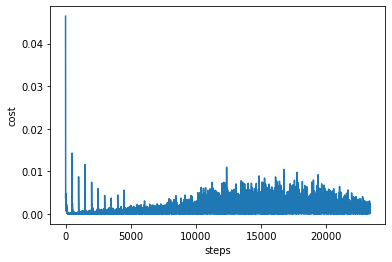

In [7]:
totle_steps = 0

for episode in range(50):
    observation = env.reset()
    epr = 0
    while True:
        env.render()
        action = RL.choose_action(observation)
        observation_, reward, done, info = env.step(action) #还有一个叫做info
        
        #修改一下默认env里面的奖励函数，怎么知道怎么改，pycharm里面搜索源文件,这样的效果更好
        position, velocity = observation_ #observation 是一个二维列表，把位置和速度提取出来
#         print(observation_)
#         print(position)
#         print(velocity)
        reward = abs(position - (-0.5))
        
        RL.store_transition(observation, action, reward, observation_)
        
        if totle_steps>MEMORY_SIZE: #注意！这里一定要运行够了MemorySIze才能学习，不然树还没建成，不能跑
            RL.learn()
        epr += reward
        if done:
            print('eposode: ', episode)
            print('epsilon: ',round(RL.epsilon,2))
            print('epr: ',epr)
            break
            
        observation = observation_
        totle_steps += 1
        
RL.plot_cost()
wights = RL.eval_net.save_weights('priority_car_weights.h5')

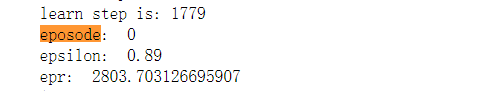

# 这是没有使用priority的普通DQN的结果

In [7]:
RL_nature = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=env.observation_space.shape[0],
                  memory_size=MEMORY_SIZE,
                  e_greedy_increment=0.0005,
                  prioritized=False)

eposode:  0
epsilon:  0
epr:  1511.5064844603603
learn step is: 0

目标模型的参数已经被替换。

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autoc

learn step is: 361
learn step is: 362
learn step is: 363
learn step is: 364
learn step is: 365
learn step is: 366
learn step is: 367
learn step is: 368
learn step is: 369
learn step is: 370
learn step is: 371
learn step is: 372
learn step is: 373
learn step is: 374
learn step is: 375
learn step is: 376
learn step is: 377
learn step is: 378
learn step is: 379
learn step is: 380
learn step is: 381
learn step is: 382
learn step is: 383
learn step is: 384
learn step is: 385
learn step is: 386
learn step is: 387
learn step is: 388
learn step is: 389
learn step is: 390
learn step is: 391
learn step is: 392
learn step is: 393
learn step is: 394
learn step is: 395
learn step is: 396
learn step is: 397
learn step is: 398
learn step is: 399
learn step is: 400
learn step is: 401
learn step is: 402
learn step is: 403
learn step is: 404
learn step is: 405
learn step is: 406
learn step is: 407
learn step is: 408
learn step is: 409
learn step is: 410
learn step is: 411
learn step is: 412
learn step i

learn step is: 799
learn step is: 800
learn step is: 801
learn step is: 802
learn step is: 803
learn step is: 804
learn step is: 805
learn step is: 806
learn step is: 807
learn step is: 808
learn step is: 809
learn step is: 810
learn step is: 811
learn step is: 812
learn step is: 813
learn step is: 814
learn step is: 815
learn step is: 816
learn step is: 817
learn step is: 818
learn step is: 819
learn step is: 820
learn step is: 821
learn step is: 822
learn step is: 823
learn step is: 824
learn step is: 825
learn step is: 826
learn step is: 827
learn step is: 828
learn step is: 829
learn step is: 830
learn step is: 831
learn step is: 832
learn step is: 833
learn step is: 834
learn step is: 835
learn step is: 836
learn step is: 837
learn step is: 838
learn step is: 839
learn step is: 840
learn step is: 841
learn step is: 842
learn step is: 843
learn step is: 844
learn step is: 845
learn step is: 846
learn step is: 847
learn step is: 848
learn step is: 849
learn step is: 850
learn step i

learn step is: 1229
learn step is: 1230
learn step is: 1231
learn step is: 1232
learn step is: 1233
learn step is: 1234
learn step is: 1235
learn step is: 1236
learn step is: 1237
learn step is: 1238
learn step is: 1239
learn step is: 1240
learn step is: 1241
learn step is: 1242
learn step is: 1243
learn step is: 1244
learn step is: 1245
learn step is: 1246
learn step is: 1247
learn step is: 1248
learn step is: 1249
learn step is: 1250
learn step is: 1251
learn step is: 1252
learn step is: 1253
learn step is: 1254
learn step is: 1255
learn step is: 1256
learn step is: 1257
learn step is: 1258
learn step is: 1259
learn step is: 1260
learn step is: 1261
learn step is: 1262
learn step is: 1263
learn step is: 1264
learn step is: 1265
learn step is: 1266
learn step is: 1267
learn step is: 1268
learn step is: 1269
learn step is: 1270
learn step is: 1271
learn step is: 1272
learn step is: 1273
learn step is: 1274
learn step is: 1275
learn step is: 1276
learn step is: 1277
learn step is: 1278


learn step is: 1641
learn step is: 1642
learn step is: 1643
learn step is: 1644
learn step is: 1645
learn step is: 1646
learn step is: 1647
learn step is: 1648
learn step is: 1649
learn step is: 1650
learn step is: 1651
learn step is: 1652
learn step is: 1653
learn step is: 1654
learn step is: 1655
learn step is: 1656
learn step is: 1657
learn step is: 1658
learn step is: 1659
learn step is: 1660
learn step is: 1661
learn step is: 1662
learn step is: 1663
learn step is: 1664
learn step is: 1665
learn step is: 1666
learn step is: 1667
learn step is: 1668
learn step is: 1669
learn step is: 1670
learn step is: 1671
learn step is: 1672
learn step is: 1673
learn step is: 1674
learn step is: 1675
learn step is: 1676
learn step is: 1677
learn step is: 1678
learn step is: 1679
learn step is: 1680
learn step is: 1681
learn step is: 1682
learn step is: 1683
learn step is: 1684
learn step is: 1685
learn step is: 1686
learn step is: 1687
learn step is: 1688
learn step is: 1689
learn step is: 1690


learn step is: 2052
learn step is: 2053
learn step is: 2054
learn step is: 2055
learn step is: 2056
learn step is: 2057
learn step is: 2058
learn step is: 2059
learn step is: 2060
learn step is: 2061
learn step is: 2062
learn step is: 2063
learn step is: 2064
learn step is: 2065
learn step is: 2066
learn step is: 2067
learn step is: 2068
learn step is: 2069
learn step is: 2070
learn step is: 2071
learn step is: 2072
learn step is: 2073
learn step is: 2074
learn step is: 2075
learn step is: 2076
learn step is: 2077
learn step is: 2078
learn step is: 2079
learn step is: 2080
learn step is: 2081
learn step is: 2082
learn step is: 2083
learn step is: 2084
learn step is: 2085
learn step is: 2086
learn step is: 2087
learn step is: 2088
learn step is: 2089
learn step is: 2090
learn step is: 2091
learn step is: 2092
learn step is: 2093
learn step is: 2094
learn step is: 2095
learn step is: 2096
learn step is: 2097
learn step is: 2098
learn step is: 2099
learn step is: 2100
learn step is: 2101


learn step is: 2471
learn step is: 2472
learn step is: 2473
learn step is: 2474
learn step is: 2475
learn step is: 2476
learn step is: 2477
learn step is: 2478
learn step is: 2479
learn step is: 2480
learn step is: 2481
learn step is: 2482
learn step is: 2483
learn step is: 2484
learn step is: 2485
learn step is: 2486
learn step is: 2487
learn step is: 2488
learn step is: 2489
learn step is: 2490
learn step is: 2491
learn step is: 2492
learn step is: 2493
learn step is: 2494
learn step is: 2495
learn step is: 2496
learn step is: 2497
learn step is: 2498
learn step is: 2499
learn step is: 2500

目标模型的参数已经被替换。
learn step is: 2501
learn step is: 2502
learn step is: 2503
learn step is: 2504
learn step is: 2505
learn step is: 2506
learn step is: 2507
learn step is: 2508
learn step is: 2509
learn step is: 2510
learn step is: 2511
learn step is: 2512
learn step is: 2513
learn step is: 2514
learn step is: 2515
learn step is: 2516
learn step is: 2517
learn step is: 2518
learn step is: 2519
learn

learn step is: 2889
learn step is: 2890
learn step is: 2891
learn step is: 2892
learn step is: 2893
learn step is: 2894
learn step is: 2895
learn step is: 2896
learn step is: 2897
learn step is: 2898
learn step is: 2899
learn step is: 2900
learn step is: 2901
learn step is: 2902
learn step is: 2903
learn step is: 2904
learn step is: 2905
learn step is: 2906
learn step is: 2907
learn step is: 2908
learn step is: 2909
learn step is: 2910
learn step is: 2911
learn step is: 2912
learn step is: 2913
learn step is: 2914
learn step is: 2915
learn step is: 2916
learn step is: 2917
learn step is: 2918
learn step is: 2919
learn step is: 2920
learn step is: 2921
learn step is: 2922
learn step is: 2923
learn step is: 2924
learn step is: 2925
learn step is: 2926
learn step is: 2927
learn step is: 2928
learn step is: 2929
learn step is: 2930
learn step is: 2931
learn step is: 2932
learn step is: 2933
learn step is: 2934
learn step is: 2935
learn step is: 2936
learn step is: 2937
learn step is: 2938


learn step is: 3301
learn step is: 3302
learn step is: 3303
eposode:  1
epsilon:  0.9
epr:  1140.2971809255585
learn step is: 3304
learn step is: 3305
learn step is: 3306
learn step is: 3307
learn step is: 3308
learn step is: 3309
learn step is: 3310
learn step is: 3311
learn step is: 3312
learn step is: 3313
learn step is: 3314
learn step is: 3315
learn step is: 3316
learn step is: 3317
learn step is: 3318
learn step is: 3319
learn step is: 3320
learn step is: 3321
learn step is: 3322
learn step is: 3323
learn step is: 3324
learn step is: 3325
learn step is: 3326
learn step is: 3327
learn step is: 3328
learn step is: 3329
learn step is: 3330
learn step is: 3331
learn step is: 3332
learn step is: 3333
learn step is: 3334
learn step is: 3335
learn step is: 3336
learn step is: 3337
learn step is: 3338
learn step is: 3339
learn step is: 3340
learn step is: 3341
learn step is: 3342
learn step is: 3343
learn step is: 3344
learn step is: 3345
learn step is: 3346
learn step is: 3347
learn ste

learn step is: 3720
learn step is: 3721
learn step is: 3722
learn step is: 3723
learn step is: 3724
learn step is: 3725
learn step is: 3726
learn step is: 3727
learn step is: 3728
learn step is: 3729
learn step is: 3730
learn step is: 3731
learn step is: 3732
learn step is: 3733
learn step is: 3734
learn step is: 3735
learn step is: 3736
learn step is: 3737
learn step is: 3738
learn step is: 3739
learn step is: 3740
learn step is: 3741
learn step is: 3742
learn step is: 3743
learn step is: 3744
learn step is: 3745
learn step is: 3746
learn step is: 3747
learn step is: 3748
learn step is: 3749
learn step is: 3750
learn step is: 3751
learn step is: 3752
learn step is: 3753
learn step is: 3754
learn step is: 3755
learn step is: 3756
learn step is: 3757
learn step is: 3758
learn step is: 3759
learn step is: 3760
learn step is: 3761
learn step is: 3762
learn step is: 3763
learn step is: 3764
learn step is: 3765
learn step is: 3766
learn step is: 3767
learn step is: 3768
learn step is: 3769


learn step is: 4135
learn step is: 4136
learn step is: 4137
learn step is: 4138
learn step is: 4139
learn step is: 4140
learn step is: 4141
learn step is: 4142
learn step is: 4143
learn step is: 4144
learn step is: 4145
learn step is: 4146
learn step is: 4147
learn step is: 4148
learn step is: 4149
learn step is: 4150
learn step is: 4151
learn step is: 4152
learn step is: 4153
learn step is: 4154
learn step is: 4155
learn step is: 4156
learn step is: 4157
learn step is: 4158
learn step is: 4159
learn step is: 4160
learn step is: 4161
learn step is: 4162
learn step is: 4163
learn step is: 4164
learn step is: 4165
learn step is: 4166
learn step is: 4167
learn step is: 4168
learn step is: 4169
learn step is: 4170
learn step is: 4171
learn step is: 4172
learn step is: 4173
learn step is: 4174
learn step is: 4175
learn step is: 4176
learn step is: 4177
learn step is: 4178
learn step is: 4179
learn step is: 4180
learn step is: 4181
learn step is: 4182
learn step is: 4183
learn step is: 4184


learn step is: 4542
learn step is: 4543
learn step is: 4544
learn step is: 4545
learn step is: 4546
learn step is: 4547
learn step is: 4548
learn step is: 4549
learn step is: 4550
learn step is: 4551
learn step is: 4552
learn step is: 4553
learn step is: 4554
learn step is: 4555
learn step is: 4556
learn step is: 4557
learn step is: 4558
learn step is: 4559
learn step is: 4560
learn step is: 4561
learn step is: 4562
learn step is: 4563
learn step is: 4564
learn step is: 4565
learn step is: 4566
learn step is: 4567
learn step is: 4568
learn step is: 4569
learn step is: 4570
learn step is: 4571
learn step is: 4572
learn step is: 4573
learn step is: 4574
learn step is: 4575
learn step is: 4576
learn step is: 4577
learn step is: 4578
learn step is: 4579
learn step is: 4580
learn step is: 4581
learn step is: 4582
learn step is: 4583
learn step is: 4584
learn step is: 4585
learn step is: 4586
learn step is: 4587
learn step is: 4588
learn step is: 4589
learn step is: 4590
learn step is: 4591


learn step is: 4958
learn step is: 4959
learn step is: 4960
learn step is: 4961
learn step is: 4962
learn step is: 4963
learn step is: 4964
learn step is: 4965
learn step is: 4966
learn step is: 4967
learn step is: 4968
learn step is: 4969
learn step is: 4970
learn step is: 4971
learn step is: 4972
learn step is: 4973
learn step is: 4974
learn step is: 4975
learn step is: 4976
learn step is: 4977
learn step is: 4978
learn step is: 4979
learn step is: 4980
learn step is: 4981
learn step is: 4982
learn step is: 4983
learn step is: 4984
learn step is: 4985
learn step is: 4986
learn step is: 4987
learn step is: 4988
learn step is: 4989
learn step is: 4990
learn step is: 4991
learn step is: 4992
learn step is: 4993
learn step is: 4994
learn step is: 4995
learn step is: 4996
learn step is: 4997
learn step is: 4998
learn step is: 4999
learn step is: 5000

目标模型的参数已经被替换。
learn step is: 5001
learn step is: 5002
learn step is: 5003
learn step is: 5004
learn step is: 5005
learn step is: 5006
learn

learn step is: 5376
learn step is: 5377
learn step is: 5378
learn step is: 5379
learn step is: 5380
learn step is: 5381
learn step is: 5382
learn step is: 5383
learn step is: 5384
learn step is: 5385
learn step is: 5386
learn step is: 5387
learn step is: 5388
learn step is: 5389
learn step is: 5390
learn step is: 5391
learn step is: 5392
learn step is: 5393
learn step is: 5394
learn step is: 5395
learn step is: 5396
learn step is: 5397
learn step is: 5398
learn step is: 5399
learn step is: 5400
learn step is: 5401
learn step is: 5402
learn step is: 5403
learn step is: 5404
learn step is: 5405
learn step is: 5406
learn step is: 5407
learn step is: 5408
learn step is: 5409
learn step is: 5410
learn step is: 5411
learn step is: 5412
learn step is: 5413
learn step is: 5414
learn step is: 5415
learn step is: 5416
learn step is: 5417
learn step is: 5418
learn step is: 5419
learn step is: 5420
learn step is: 5421
learn step is: 5422
learn step is: 5423
learn step is: 5424
learn step is: 5425


learn step is: 5792
learn step is: 5793
learn step is: 5794
learn step is: 5795
learn step is: 5796
learn step is: 5797
learn step is: 5798
learn step is: 5799
learn step is: 5800
learn step is: 5801
learn step is: 5802
learn step is: 5803
learn step is: 5804
learn step is: 5805
learn step is: 5806
learn step is: 5807
learn step is: 5808
learn step is: 5809
learn step is: 5810
learn step is: 5811
learn step is: 5812
learn step is: 5813
learn step is: 5814
learn step is: 5815
learn step is: 5816
learn step is: 5817
learn step is: 5818
learn step is: 5819
learn step is: 5820
learn step is: 5821
learn step is: 5822
learn step is: 5823
learn step is: 5824
learn step is: 5825
learn step is: 5826
learn step is: 5827
learn step is: 5828
learn step is: 5829
learn step is: 5830
learn step is: 5831
learn step is: 5832
learn step is: 5833
learn step is: 5834
learn step is: 5835
learn step is: 5836
learn step is: 5837
learn step is: 5838
learn step is: 5839
learn step is: 5840
learn step is: 5841


learn step is: 6209
learn step is: 6210
learn step is: 6211
learn step is: 6212
learn step is: 6213
learn step is: 6214
learn step is: 6215
learn step is: 6216
learn step is: 6217
learn step is: 6218
learn step is: 6219
learn step is: 6220
learn step is: 6221
learn step is: 6222
learn step is: 6223
learn step is: 6224
learn step is: 6225
learn step is: 6226
learn step is: 6227
learn step is: 6228
learn step is: 6229
learn step is: 6230
learn step is: 6231
learn step is: 6232
learn step is: 6233
learn step is: 6234
learn step is: 6235
learn step is: 6236
learn step is: 6237
learn step is: 6238
learn step is: 6239
learn step is: 6240
learn step is: 6241
learn step is: 6242
learn step is: 6243
learn step is: 6244
learn step is: 6245
learn step is: 6246
learn step is: 6247
learn step is: 6248
learn step is: 6249
learn step is: 6250
learn step is: 6251
learn step is: 6252
learn step is: 6253
learn step is: 6254
learn step is: 6255
learn step is: 6256
learn step is: 6257
learn step is: 6258


learn step is: 7023
learn step is: 7024
learn step is: 7025
learn step is: 7026
learn step is: 7027
learn step is: 7028
learn step is: 7029
learn step is: 7030
learn step is: 7031
learn step is: 7032
learn step is: 7033
learn step is: 7034
learn step is: 7035
learn step is: 7036
learn step is: 7037
learn step is: 7038
learn step is: 7039
learn step is: 7040
learn step is: 7041
learn step is: 7042
learn step is: 7043
learn step is: 7044
learn step is: 7045
learn step is: 7046
learn step is: 7047
learn step is: 7048
learn step is: 7049
learn step is: 7050
learn step is: 7051
learn step is: 7052
learn step is: 7053
learn step is: 7054
learn step is: 7055
learn step is: 7056
learn step is: 7057
learn step is: 7058
learn step is: 7059
learn step is: 7060
learn step is: 7061
learn step is: 7062
learn step is: 7063
learn step is: 7064
learn step is: 7065
learn step is: 7066
learn step is: 7067
learn step is: 7068
learn step is: 7069
learn step is: 7070
learn step is: 7071
learn step is: 7072


learn step is: 7438
learn step is: 7439
learn step is: 7440
learn step is: 7441
learn step is: 7442
learn step is: 7443
learn step is: 7444
learn step is: 7445
learn step is: 7446
learn step is: 7447
learn step is: 7448
learn step is: 7449
learn step is: 7450
learn step is: 7451
learn step is: 7452
learn step is: 7453
learn step is: 7454
learn step is: 7455
learn step is: 7456
learn step is: 7457
learn step is: 7458
learn step is: 7459
learn step is: 7460
learn step is: 7461
learn step is: 7462
learn step is: 7463
learn step is: 7464
learn step is: 7465
learn step is: 7466
learn step is: 7467
learn step is: 7468
learn step is: 7469
learn step is: 7470
learn step is: 7471
learn step is: 7472
learn step is: 7473
learn step is: 7474
learn step is: 7475
learn step is: 7476
learn step is: 7477
learn step is: 7478
learn step is: 7479
learn step is: 7480
learn step is: 7481
learn step is: 7482
learn step is: 7483
learn step is: 7484
learn step is: 7485
learn step is: 7486
learn step is: 7487


learn step is: 7849
learn step is: 7850
learn step is: 7851
learn step is: 7852
learn step is: 7853
learn step is: 7854
learn step is: 7855
learn step is: 7856
learn step is: 7857
learn step is: 7858
learn step is: 7859
learn step is: 7860
learn step is: 7861
learn step is: 7862
learn step is: 7863
learn step is: 7864
learn step is: 7865
learn step is: 7866
learn step is: 7867
learn step is: 7868
learn step is: 7869
learn step is: 7870
learn step is: 7871
learn step is: 7872
learn step is: 7873
learn step is: 7874
learn step is: 7875
learn step is: 7876
learn step is: 7877
learn step is: 7878
learn step is: 7879
learn step is: 7880
learn step is: 7881
learn step is: 7882
learn step is: 7883
learn step is: 7884
learn step is: 7885
learn step is: 7886
learn step is: 7887
learn step is: 7888
learn step is: 7889
learn step is: 7890
learn step is: 7891
learn step is: 7892
learn step is: 7893
learn step is: 7894
learn step is: 7895
learn step is: 7896
learn step is: 7897
learn step is: 7898


learn step is: 8270
learn step is: 8271
learn step is: 8272
learn step is: 8273
learn step is: 8274
learn step is: 8275
learn step is: 8276
learn step is: 8277
learn step is: 8278
learn step is: 8279
learn step is: 8280
learn step is: 8281
learn step is: 8282
learn step is: 8283
learn step is: 8284
learn step is: 8285
learn step is: 8286
learn step is: 8287
learn step is: 8288
learn step is: 8289
learn step is: 8290
learn step is: 8291
learn step is: 8292
learn step is: 8293
learn step is: 8294
learn step is: 8295
learn step is: 8296
learn step is: 8297
learn step is: 8298
learn step is: 8299
learn step is: 8300
learn step is: 8301
learn step is: 8302
learn step is: 8303
learn step is: 8304
learn step is: 8305
learn step is: 8306
learn step is: 8307
learn step is: 8308
learn step is: 8309
learn step is: 8310
learn step is: 8311
learn step is: 8312
learn step is: 8313
learn step is: 8314
learn step is: 8315
learn step is: 8316
learn step is: 8317
learn step is: 8318
learn step is: 8319


learn step is: 8683
learn step is: 8684
learn step is: 8685
learn step is: 8686
learn step is: 8687
learn step is: 8688
learn step is: 8689
learn step is: 8690
learn step is: 8691
learn step is: 8692
learn step is: 8693
learn step is: 8694
learn step is: 8695
learn step is: 8696
learn step is: 8697
learn step is: 8698
learn step is: 8699
learn step is: 8700
learn step is: 8701
learn step is: 8702
learn step is: 8703
learn step is: 8704
learn step is: 8705
learn step is: 8706
learn step is: 8707
learn step is: 8708
learn step is: 8709
learn step is: 8710
learn step is: 8711
learn step is: 8712
learn step is: 8713
learn step is: 8714
learn step is: 8715
learn step is: 8716
learn step is: 8717
learn step is: 8718
learn step is: 8719
learn step is: 8720
learn step is: 8721
learn step is: 8722
learn step is: 8723
learn step is: 8724
learn step is: 8725
learn step is: 8726
learn step is: 8727
learn step is: 8728
learn step is: 8729
learn step is: 8730
learn step is: 8731
learn step is: 8732


learn step is: 9090
learn step is: 9091
learn step is: 9092
learn step is: 9093
learn step is: 9094
learn step is: 9095
learn step is: 9096
learn step is: 9097
learn step is: 9098
learn step is: 9099
learn step is: 9100
learn step is: 9101
learn step is: 9102
learn step is: 9103
learn step is: 9104
learn step is: 9105
learn step is: 9106
learn step is: 9107
learn step is: 9108
learn step is: 9109
learn step is: 9110
learn step is: 9111
learn step is: 9112
learn step is: 9113
learn step is: 9114
learn step is: 9115
learn step is: 9116
learn step is: 9117
learn step is: 9118
learn step is: 9119
learn step is: 9120
learn step is: 9121
learn step is: 9122
learn step is: 9123
learn step is: 9124
learn step is: 9125
learn step is: 9126
learn step is: 9127
learn step is: 9128
learn step is: 9129
learn step is: 9130
learn step is: 9131
learn step is: 9132
learn step is: 9133
learn step is: 9134
learn step is: 9135
learn step is: 9136
learn step is: 9137
learn step is: 9138
learn step is: 9139


learn step is: 9906
learn step is: 9907
learn step is: 9908
learn step is: 9909
learn step is: 9910
learn step is: 9911
learn step is: 9912
learn step is: 9913
learn step is: 9914
learn step is: 9915
learn step is: 9916
learn step is: 9917
learn step is: 9918
learn step is: 9919
learn step is: 9920
learn step is: 9921
learn step is: 9922
learn step is: 9923
learn step is: 9924
learn step is: 9925
learn step is: 9926
learn step is: 9927
learn step is: 9928
learn step is: 9929
learn step is: 9930
learn step is: 9931
learn step is: 9932
learn step is: 9933
learn step is: 9934
learn step is: 9935
learn step is: 9936
learn step is: 9937
learn step is: 9938
learn step is: 9939
learn step is: 9940
learn step is: 9941
learn step is: 9942
learn step is: 9943
learn step is: 9944
learn step is: 9945
learn step is: 9946
learn step is: 9947
learn step is: 9948
learn step is: 9949
learn step is: 9950
learn step is: 9951
learn step is: 9952
learn step is: 9953
learn step is: 9954
learn step is: 9955


learn step is: 10300
learn step is: 10301
learn step is: 10302
learn step is: 10303
learn step is: 10304
learn step is: 10305
learn step is: 10306
learn step is: 10307
learn step is: 10308
learn step is: 10309
learn step is: 10310
learn step is: 10311
learn step is: 10312
learn step is: 10313
learn step is: 10314
learn step is: 10315
learn step is: 10316
learn step is: 10317
learn step is: 10318
learn step is: 10319
learn step is: 10320
learn step is: 10321
learn step is: 10322
learn step is: 10323
learn step is: 10324
learn step is: 10325
learn step is: 10326
learn step is: 10327
learn step is: 10328
learn step is: 10329
learn step is: 10330
learn step is: 10331
learn step is: 10332
learn step is: 10333
learn step is: 10334
learn step is: 10335
learn step is: 10336
learn step is: 10337
learn step is: 10338
learn step is: 10339
learn step is: 10340
learn step is: 10341
learn step is: 10342
learn step is: 10343
learn step is: 10344
learn step is: 10345
learn step is: 10346
learn step is

learn step is: 10696
learn step is: 10697
learn step is: 10698
learn step is: 10699
learn step is: 10700
learn step is: 10701
learn step is: 10702
learn step is: 10703
learn step is: 10704
learn step is: 10705
learn step is: 10706
learn step is: 10707
learn step is: 10708
learn step is: 10709
learn step is: 10710
learn step is: 10711
learn step is: 10712
learn step is: 10713
learn step is: 10714
learn step is: 10715
learn step is: 10716
learn step is: 10717
learn step is: 10718
learn step is: 10719
learn step is: 10720
learn step is: 10721
learn step is: 10722
learn step is: 10723
learn step is: 10724
learn step is: 10725
learn step is: 10726
learn step is: 10727
learn step is: 10728
learn step is: 10729
learn step is: 10730
learn step is: 10731
learn step is: 10732
learn step is: 10733
learn step is: 10734
learn step is: 10735
learn step is: 10736
learn step is: 10737
learn step is: 10738
learn step is: 10739
learn step is: 10740
learn step is: 10741
learn step is: 10742
learn step is

learn step is: 11086
learn step is: 11087
learn step is: 11088
learn step is: 11089
learn step is: 11090
learn step is: 11091
learn step is: 11092
learn step is: 11093
learn step is: 11094
learn step is: 11095
learn step is: 11096
learn step is: 11097
learn step is: 11098
learn step is: 11099
learn step is: 11100
learn step is: 11101
learn step is: 11102
learn step is: 11103
learn step is: 11104
learn step is: 11105
learn step is: 11106
learn step is: 11107
learn step is: 11108
learn step is: 11109
learn step is: 11110
learn step is: 11111
learn step is: 11112
learn step is: 11113
learn step is: 11114
learn step is: 11115
learn step is: 11116
learn step is: 11117
learn step is: 11118
learn step is: 11119
learn step is: 11120
learn step is: 11121
learn step is: 11122
learn step is: 11123
learn step is: 11124
learn step is: 11125
learn step is: 11126
learn step is: 11127
learn step is: 11128
learn step is: 11129
learn step is: 11130
learn step is: 11131
learn step is: 11132
learn step is

learn step is: 11484
learn step is: 11485
learn step is: 11486
learn step is: 11487
learn step is: 11488
learn step is: 11489
learn step is: 11490
learn step is: 11491
learn step is: 11492
learn step is: 11493
learn step is: 11494
learn step is: 11495
learn step is: 11496
learn step is: 11497
learn step is: 11498
learn step is: 11499
learn step is: 11500

目标模型的参数已经被替换。
learn step is: 11501
learn step is: 11502
learn step is: 11503
learn step is: 11504
learn step is: 11505
learn step is: 11506
learn step is: 11507
learn step is: 11508
learn step is: 11509
learn step is: 11510
learn step is: 11511
learn step is: 11512
learn step is: 11513
learn step is: 11514
learn step is: 11515
learn step is: 11516
learn step is: 11517
learn step is: 11518
learn step is: 11519
learn step is: 11520
learn step is: 11521
learn step is: 11522
learn step is: 11523
learn step is: 11524
learn step is: 11525
learn step is: 11526
learn step is: 11527
learn step is: 11528
learn step is: 11529
learn step is: 1153

learn step is: 11884
learn step is: 11885
learn step is: 11886
learn step is: 11887
learn step is: 11888
learn step is: 11889
learn step is: 11890
learn step is: 11891
learn step is: 11892
learn step is: 11893
learn step is: 11894
learn step is: 11895
learn step is: 11896
learn step is: 11897
learn step is: 11898
learn step is: 11899
learn step is: 11900
learn step is: 11901
learn step is: 11902
learn step is: 11903
learn step is: 11904
learn step is: 11905
learn step is: 11906
learn step is: 11907
learn step is: 11908
learn step is: 11909
learn step is: 11910
learn step is: 11911
learn step is: 11912
learn step is: 11913
learn step is: 11914
learn step is: 11915
learn step is: 11916
learn step is: 11917
learn step is: 11918
learn step is: 11919
learn step is: 11920
learn step is: 11921
learn step is: 11922
learn step is: 11923
learn step is: 11924
learn step is: 11925
learn step is: 11926
learn step is: 11927
learn step is: 11928
learn step is: 11929
learn step is: 11930
learn step is

learn step is: 12282
learn step is: 12283
learn step is: 12284
learn step is: 12285
learn step is: 12286
learn step is: 12287
learn step is: 12288
learn step is: 12289
learn step is: 12290
learn step is: 12291
learn step is: 12292
learn step is: 12293
learn step is: 12294
learn step is: 12295
learn step is: 12296
learn step is: 12297
learn step is: 12298
learn step is: 12299
learn step is: 12300
learn step is: 12301
learn step is: 12302
learn step is: 12303
learn step is: 12304
learn step is: 12305
learn step is: 12306
learn step is: 12307
learn step is: 12308
learn step is: 12309
learn step is: 12310
learn step is: 12311
learn step is: 12312
learn step is: 12313
learn step is: 12314
learn step is: 12315
learn step is: 12316
learn step is: 12317
learn step is: 12318
learn step is: 12319
learn step is: 12320
learn step is: 12321
learn step is: 12322
learn step is: 12323
learn step is: 12324
learn step is: 12325
learn step is: 12326
learn step is: 12327
learn step is: 12328
learn step is

learn step is: 12677
learn step is: 12678
learn step is: 12679
learn step is: 12680
learn step is: 12681
learn step is: 12682
learn step is: 12683
learn step is: 12684
learn step is: 12685
learn step is: 12686
learn step is: 12687
learn step is: 12688
learn step is: 12689
learn step is: 12690
learn step is: 12691
learn step is: 12692
learn step is: 12693
learn step is: 12694
learn step is: 12695
learn step is: 12696
learn step is: 12697
learn step is: 12698
learn step is: 12699
learn step is: 12700
learn step is: 12701
learn step is: 12702
learn step is: 12703
learn step is: 12704
learn step is: 12705
learn step is: 12706
learn step is: 12707
learn step is: 12708
learn step is: 12709
learn step is: 12710
learn step is: 12711
learn step is: 12712
learn step is: 12713
learn step is: 12714
learn step is: 12715
learn step is: 12716
learn step is: 12717
learn step is: 12718
learn step is: 12719
learn step is: 12720
learn step is: 12721
learn step is: 12722
learn step is: 12723
learn step is

learn step is: 13065
learn step is: 13066
learn step is: 13067
learn step is: 13068
learn step is: 13069
learn step is: 13070
learn step is: 13071
learn step is: 13072
learn step is: 13073
learn step is: 13074
learn step is: 13075
learn step is: 13076
learn step is: 13077
learn step is: 13078
learn step is: 13079
learn step is: 13080
learn step is: 13081
learn step is: 13082
learn step is: 13083
learn step is: 13084
learn step is: 13085
learn step is: 13086
learn step is: 13087
learn step is: 13088
learn step is: 13089
learn step is: 13090
learn step is: 13091
learn step is: 13092
learn step is: 13093
learn step is: 13094
learn step is: 13095
learn step is: 13096
learn step is: 13097
learn step is: 13098
learn step is: 13099
learn step is: 13100
learn step is: 13101
learn step is: 13102
learn step is: 13103
learn step is: 13104
learn step is: 13105
learn step is: 13106
learn step is: 13107
learn step is: 13108
learn step is: 13109
learn step is: 13110
learn step is: 13111
learn step is

learn step is: 13456
learn step is: 13457
learn step is: 13458
learn step is: 13459
learn step is: 13460
learn step is: 13461
learn step is: 13462
learn step is: 13463
learn step is: 13464
learn step is: 13465
learn step is: 13466
learn step is: 13467
learn step is: 13468
learn step is: 13469
learn step is: 13470
learn step is: 13471
learn step is: 13472
learn step is: 13473
learn step is: 13474
learn step is: 13475
learn step is: 13476
learn step is: 13477
learn step is: 13478
learn step is: 13479
learn step is: 13480
learn step is: 13481
learn step is: 13482
learn step is: 13483
learn step is: 13484
learn step is: 13485
learn step is: 13486
learn step is: 13487
learn step is: 13488
learn step is: 13489
learn step is: 13490
learn step is: 13491
learn step is: 13492
learn step is: 13493
learn step is: 13494
learn step is: 13495
learn step is: 13496
learn step is: 13497
learn step is: 13498
learn step is: 13499
learn step is: 13500

目标模型的参数已经被替换。
learn step is: 13501
learn step is: 1350

learn step is: 13847
learn step is: 13848
learn step is: 13849
learn step is: 13850
learn step is: 13851
learn step is: 13852
learn step is: 13853
learn step is: 13854
learn step is: 13855
learn step is: 13856
learn step is: 13857
learn step is: 13858
learn step is: 13859
learn step is: 13860
learn step is: 13861
learn step is: 13862
learn step is: 13863
learn step is: 13864
learn step is: 13865
learn step is: 13866
learn step is: 13867
learn step is: 13868
learn step is: 13869
learn step is: 13870
learn step is: 13871
learn step is: 13872
learn step is: 13873
learn step is: 13874
learn step is: 13875
learn step is: 13876
learn step is: 13877
learn step is: 13878
learn step is: 13879
learn step is: 13880
learn step is: 13881
learn step is: 13882
learn step is: 13883
learn step is: 13884
learn step is: 13885
learn step is: 13886
learn step is: 13887
learn step is: 13888
learn step is: 13889
learn step is: 13890
learn step is: 13891
learn step is: 13892
learn step is: 13893
learn step is

learn step is: 14238
learn step is: 14239
learn step is: 14240
learn step is: 14241
learn step is: 14242
learn step is: 14243
learn step is: 14244
learn step is: 14245
learn step is: 14246
learn step is: 14247
learn step is: 14248
learn step is: 14249
learn step is: 14250
learn step is: 14251
learn step is: 14252
learn step is: 14253
learn step is: 14254
learn step is: 14255
learn step is: 14256
learn step is: 14257
learn step is: 14258
learn step is: 14259
learn step is: 14260
learn step is: 14261
learn step is: 14262
learn step is: 14263
learn step is: 14264
learn step is: 14265
learn step is: 14266
learn step is: 14267
learn step is: 14268
learn step is: 14269
learn step is: 14270
learn step is: 14271
learn step is: 14272
learn step is: 14273
learn step is: 14274
learn step is: 14275
learn step is: 14276
learn step is: 14277
learn step is: 14278
learn step is: 14279
learn step is: 14280
learn step is: 14281
learn step is: 14282
learn step is: 14283
learn step is: 14284
learn step is

learn step is: 14628
learn step is: 14629
learn step is: 14630
learn step is: 14631
learn step is: 14632
learn step is: 14633
learn step is: 14634
learn step is: 14635
learn step is: 14636
learn step is: 14637
learn step is: 14638
learn step is: 14639
learn step is: 14640
learn step is: 14641
learn step is: 14642
learn step is: 14643
learn step is: 14644
learn step is: 14645
learn step is: 14646
learn step is: 14647
learn step is: 14648
learn step is: 14649
learn step is: 14650
learn step is: 14651
learn step is: 14652
learn step is: 14653
learn step is: 14654
learn step is: 14655
learn step is: 14656
learn step is: 14657
learn step is: 14658
learn step is: 14659
learn step is: 14660
learn step is: 14661
learn step is: 14662
learn step is: 14663
learn step is: 14664
learn step is: 14665
learn step is: 14666
learn step is: 14667
learn step is: 14668
learn step is: 14669
learn step is: 14670
learn step is: 14671
learn step is: 14672
learn step is: 14673
learn step is: 14674
learn step is

learn step is: 15020
learn step is: 15021
learn step is: 15022
learn step is: 15023
learn step is: 15024
learn step is: 15025
learn step is: 15026
learn step is: 15027
learn step is: 15028
learn step is: 15029
learn step is: 15030
learn step is: 15031
learn step is: 15032
learn step is: 15033
learn step is: 15034
learn step is: 15035
learn step is: 15036
learn step is: 15037
learn step is: 15038
learn step is: 15039
learn step is: 15040
learn step is: 15041
learn step is: 15042
learn step is: 15043
learn step is: 15044
learn step is: 15045
learn step is: 15046
learn step is: 15047
learn step is: 15048
learn step is: 15049
learn step is: 15050
learn step is: 15051
learn step is: 15052
learn step is: 15053
learn step is: 15054
learn step is: 15055
learn step is: 15056
learn step is: 15057
learn step is: 15058
learn step is: 15059
learn step is: 15060
learn step is: 15061
learn step is: 15062
learn step is: 15063
learn step is: 15064
learn step is: 15065
learn step is: 15066
learn step is

learn step is: 15414
learn step is: 15415
learn step is: 15416
learn step is: 15417
learn step is: 15418
learn step is: 15419
learn step is: 15420
learn step is: 15421
learn step is: 15422
eposode:  28
epsilon:  0.9
epr:  72.29533460131186
learn step is: 15423
learn step is: 15424
learn step is: 15425
learn step is: 15426
learn step is: 15427
learn step is: 15428
learn step is: 15429
learn step is: 15430
learn step is: 15431
learn step is: 15432
learn step is: 15433
learn step is: 15434
learn step is: 15435
learn step is: 15436
learn step is: 15437
learn step is: 15438
learn step is: 15439
learn step is: 15440
learn step is: 15441
learn step is: 15442
learn step is: 15443
learn step is: 15444
learn step is: 15445
learn step is: 15446
learn step is: 15447
learn step is: 15448
learn step is: 15449
learn step is: 15450
learn step is: 15451
learn step is: 15452
learn step is: 15453
learn step is: 15454
learn step is: 15455
learn step is: 15456
learn step is: 15457
learn step is: 15458
lear

learn step is: 15800
learn step is: 15801
learn step is: 15802
learn step is: 15803
learn step is: 15804
learn step is: 15805
learn step is: 15806
learn step is: 15807
learn step is: 15808
learn step is: 15809
learn step is: 15810
learn step is: 15811
learn step is: 15812
learn step is: 15813
learn step is: 15814
learn step is: 15815
learn step is: 15816
learn step is: 15817
learn step is: 15818
learn step is: 15819
learn step is: 15820
learn step is: 15821
learn step is: 15822
learn step is: 15823
learn step is: 15824
learn step is: 15825
learn step is: 15826
learn step is: 15827
learn step is: 15828
learn step is: 15829
learn step is: 15830
learn step is: 15831
learn step is: 15832
learn step is: 15833
learn step is: 15834
learn step is: 15835
learn step is: 15836
learn step is: 15837
learn step is: 15838
learn step is: 15839
learn step is: 15840
learn step is: 15841
learn step is: 15842
learn step is: 15843
learn step is: 15844
learn step is: 15845
learn step is: 15846
learn step is

learn step is: 16193
learn step is: 16194
learn step is: 16195
learn step is: 16196
learn step is: 16197
learn step is: 16198
learn step is: 16199
learn step is: 16200
learn step is: 16201
learn step is: 16202
learn step is: 16203
learn step is: 16204
learn step is: 16205
learn step is: 16206
learn step is: 16207
learn step is: 16208
learn step is: 16209
learn step is: 16210
learn step is: 16211
learn step is: 16212
learn step is: 16213
learn step is: 16214
learn step is: 16215
learn step is: 16216
learn step is: 16217
learn step is: 16218
learn step is: 16219
learn step is: 16220
learn step is: 16221
learn step is: 16222
learn step is: 16223
learn step is: 16224
learn step is: 16225
learn step is: 16226
learn step is: 16227
learn step is: 16228
learn step is: 16229
learn step is: 16230
learn step is: 16231
learn step is: 16232
learn step is: 16233
learn step is: 16234
learn step is: 16235
learn step is: 16236
learn step is: 16237
learn step is: 16238
learn step is: 16239
learn step is

learn step is: 16584
learn step is: 16585
learn step is: 16586
learn step is: 16587
learn step is: 16588
learn step is: 16589
learn step is: 16590
learn step is: 16591
learn step is: 16592
learn step is: 16593
learn step is: 16594
learn step is: 16595
learn step is: 16596
learn step is: 16597
learn step is: 16598
learn step is: 16599
learn step is: 16600
learn step is: 16601
learn step is: 16602
learn step is: 16603
learn step is: 16604
learn step is: 16605
learn step is: 16606
learn step is: 16607
learn step is: 16608
learn step is: 16609
learn step is: 16610
learn step is: 16611
learn step is: 16612
learn step is: 16613
learn step is: 16614
learn step is: 16615
learn step is: 16616
learn step is: 16617
learn step is: 16618
learn step is: 16619
learn step is: 16620
learn step is: 16621
learn step is: 16622
learn step is: 16623
learn step is: 16624
learn step is: 16625
learn step is: 16626
learn step is: 16627
learn step is: 16628
learn step is: 16629
learn step is: 16630
learn step is

learn step is: 16974
learn step is: 16975
learn step is: 16976
learn step is: 16977
learn step is: 16978
learn step is: 16979
learn step is: 16980
learn step is: 16981
learn step is: 16982
learn step is: 16983
learn step is: 16984
learn step is: 16985
learn step is: 16986
learn step is: 16987
learn step is: 16988
learn step is: 16989
learn step is: 16990
learn step is: 16991
learn step is: 16992
learn step is: 16993
learn step is: 16994
learn step is: 16995
learn step is: 16996
learn step is: 16997
learn step is: 16998
learn step is: 16999
learn step is: 17000

目标模型的参数已经被替换。
learn step is: 17001
learn step is: 17002
learn step is: 17003
learn step is: 17004
learn step is: 17005
learn step is: 17006
learn step is: 17007
learn step is: 17008
learn step is: 17009
learn step is: 17010
learn step is: 17011
learn step is: 17012
learn step is: 17013
learn step is: 17014
learn step is: 17015
learn step is: 17016
learn step is: 17017
learn step is: 17018
learn step is: 17019
learn step is: 1702

learn step is: 17364
learn step is: 17365
learn step is: 17366
learn step is: 17367
learn step is: 17368
learn step is: 17369
learn step is: 17370
learn step is: 17371
learn step is: 17372
learn step is: 17373
learn step is: 17374
learn step is: 17375
learn step is: 17376
learn step is: 17377
learn step is: 17378
learn step is: 17379
learn step is: 17380
learn step is: 17381
learn step is: 17382
learn step is: 17383
learn step is: 17384
learn step is: 17385
learn step is: 17386
learn step is: 17387
learn step is: 17388
learn step is: 17389
learn step is: 17390
learn step is: 17391
learn step is: 17392
learn step is: 17393
learn step is: 17394
learn step is: 17395
learn step is: 17396
learn step is: 17397
learn step is: 17398
learn step is: 17399
learn step is: 17400
learn step is: 17401
learn step is: 17402
learn step is: 17403
learn step is: 17404
learn step is: 17405
learn step is: 17406
learn step is: 17407
learn step is: 17408
learn step is: 17409
learn step is: 17410
learn step is

learn step is: 17751
learn step is: 17752
learn step is: 17753
learn step is: 17754
learn step is: 17755
learn step is: 17756
learn step is: 17757
learn step is: 17758
learn step is: 17759
learn step is: 17760
learn step is: 17761
learn step is: 17762
learn step is: 17763
learn step is: 17764
learn step is: 17765
learn step is: 17766
learn step is: 17767
learn step is: 17768
learn step is: 17769
learn step is: 17770
learn step is: 17771
learn step is: 17772
learn step is: 17773
learn step is: 17774
learn step is: 17775
learn step is: 17776
learn step is: 17777
learn step is: 17778
learn step is: 17779
learn step is: 17780
learn step is: 17781
learn step is: 17782
learn step is: 17783
learn step is: 17784
learn step is: 17785
learn step is: 17786
learn step is: 17787
learn step is: 17788
learn step is: 17789
learn step is: 17790
learn step is: 17791
learn step is: 17792
learn step is: 17793
learn step is: 17794
learn step is: 17795
learn step is: 17796
learn step is: 17797
learn step is

learn step is: 18152
learn step is: 18153
learn step is: 18154
learn step is: 18155
learn step is: 18156
learn step is: 18157
learn step is: 18158
learn step is: 18159
learn step is: 18160
learn step is: 18161
learn step is: 18162
learn step is: 18163
learn step is: 18164
learn step is: 18165
learn step is: 18166
learn step is: 18167
learn step is: 18168
learn step is: 18169
learn step is: 18170
learn step is: 18171
learn step is: 18172
learn step is: 18173
learn step is: 18174
learn step is: 18175
learn step is: 18176
learn step is: 18177
learn step is: 18178
learn step is: 18179
learn step is: 18180
learn step is: 18181
learn step is: 18182
learn step is: 18183
learn step is: 18184
learn step is: 18185
learn step is: 18186
learn step is: 18187
learn step is: 18188
learn step is: 18189
learn step is: 18190
learn step is: 18191
learn step is: 18192
learn step is: 18193
learn step is: 18194
learn step is: 18195
learn step is: 18196
learn step is: 18197
learn step is: 18198
learn step is

learn step is: 18537
learn step is: 18538
learn step is: 18539
learn step is: 18540
learn step is: 18541
learn step is: 18542
learn step is: 18543
learn step is: 18544
learn step is: 18545
learn step is: 18546
learn step is: 18547
learn step is: 18548
learn step is: 18549
learn step is: 18550
learn step is: 18551
learn step is: 18552
learn step is: 18553
learn step is: 18554
learn step is: 18555
learn step is: 18556
learn step is: 18557
learn step is: 18558
learn step is: 18559
learn step is: 18560
learn step is: 18561
learn step is: 18562
learn step is: 18563
learn step is: 18564
learn step is: 18565
learn step is: 18566
learn step is: 18567
learn step is: 18568
learn step is: 18569
learn step is: 18570
learn step is: 18571
learn step is: 18572
learn step is: 18573
learn step is: 18574
learn step is: 18575
learn step is: 18576
learn step is: 18577
learn step is: 18578
learn step is: 18579
learn step is: 18580
learn step is: 18581
learn step is: 18582
learn step is: 18583
learn step is

learn step is: 18937
learn step is: 18938
learn step is: 18939
learn step is: 18940
learn step is: 18941
learn step is: 18942
learn step is: 18943
learn step is: 18944
learn step is: 18945
learn step is: 18946
learn step is: 18947
learn step is: 18948
learn step is: 18949
learn step is: 18950
learn step is: 18951
learn step is: 18952
learn step is: 18953
learn step is: 18954
learn step is: 18955
learn step is: 18956
learn step is: 18957
learn step is: 18958
learn step is: 18959
learn step is: 18960
learn step is: 18961
learn step is: 18962
learn step is: 18963
learn step is: 18964
learn step is: 18965
learn step is: 18966
learn step is: 18967
learn step is: 18968
learn step is: 18969
learn step is: 18970
learn step is: 18971
learn step is: 18972
learn step is: 18973
learn step is: 18974
learn step is: 18975
learn step is: 18976
learn step is: 18977
learn step is: 18978
learn step is: 18979
learn step is: 18980
learn step is: 18981
learn step is: 18982
learn step is: 18983
learn step is

learn step is: 19335
learn step is: 19336
learn step is: 19337
learn step is: 19338
learn step is: 19339
learn step is: 19340
learn step is: 19341
learn step is: 19342
learn step is: 19343
learn step is: 19344
learn step is: 19345
learn step is: 19346
learn step is: 19347
learn step is: 19348
learn step is: 19349
learn step is: 19350
learn step is: 19351
learn step is: 19352
learn step is: 19353
learn step is: 19354
learn step is: 19355
learn step is: 19356
learn step is: 19357
learn step is: 19358
learn step is: 19359
learn step is: 19360
learn step is: 19361
learn step is: 19362
learn step is: 19363
eposode:  43
epsilon:  0.9
epr:  66.7915032275863
learn step is: 19364
learn step is: 19365
learn step is: 19366
learn step is: 19367
learn step is: 19368
learn step is: 19369
learn step is: 19370
learn step is: 19371
learn step is: 19372
learn step is: 19373
learn step is: 19374
learn step is: 19375
learn step is: 19376
learn step is: 19377
learn step is: 19378
learn step is: 19379
learn

learn step is: 19727
learn step is: 19728
learn step is: 19729
learn step is: 19730
learn step is: 19731
learn step is: 19732
learn step is: 19733
learn step is: 19734
learn step is: 19735
learn step is: 19736
eposode:  45
epsilon:  0.9
epr:  76.80722849758597
learn step is: 19737
learn step is: 19738
learn step is: 19739
learn step is: 19740
learn step is: 19741
learn step is: 19742
learn step is: 19743
learn step is: 19744
learn step is: 19745
learn step is: 19746
learn step is: 19747
learn step is: 19748
learn step is: 19749
learn step is: 19750
learn step is: 19751
learn step is: 19752
learn step is: 19753
learn step is: 19754
learn step is: 19755
learn step is: 19756
learn step is: 19757
learn step is: 19758
learn step is: 19759
learn step is: 19760
learn step is: 19761
learn step is: 19762
learn step is: 19763
learn step is: 19764
learn step is: 19765
learn step is: 19766
learn step is: 19767
learn step is: 19768
learn step is: 19769
learn step is: 19770
learn step is: 19771
lear

learn step is: 20117
learn step is: 20118
learn step is: 20119
learn step is: 20120
learn step is: 20121
learn step is: 20122
learn step is: 20123
learn step is: 20124
learn step is: 20125
learn step is: 20126
learn step is: 20127
learn step is: 20128
learn step is: 20129
learn step is: 20130
learn step is: 20131
learn step is: 20132
learn step is: 20133
learn step is: 20134
learn step is: 20135
learn step is: 20136
learn step is: 20137
learn step is: 20138
learn step is: 20139
learn step is: 20140
learn step is: 20141
learn step is: 20142
learn step is: 20143
learn step is: 20144
learn step is: 20145
learn step is: 20146
learn step is: 20147
learn step is: 20148
learn step is: 20149
learn step is: 20150
learn step is: 20151
learn step is: 20152
learn step is: 20153
learn step is: 20154
learn step is: 20155
learn step is: 20156
learn step is: 20157
learn step is: 20158
learn step is: 20159
learn step is: 20160
learn step is: 20161
learn step is: 20162
learn step is: 20163
learn step is

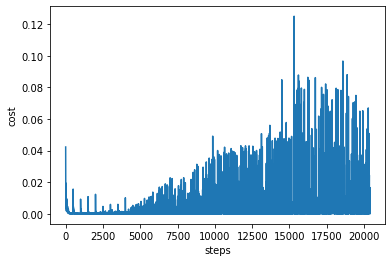

In [8]:
totle_steps = 0

for episode in range(50):
    observation = env.reset()
    epr = 0
    while True:
        env.render()
        action = RL_nature.choose_action(observation)
        observation_, reward, done, info = env.step(action) #还有一个叫做info
        
        #修改一下默认env里面的奖励函数，怎么知道怎么改，pycharm里面搜索源文件,这样的效果更好
        position, velocity = observation_ #observation 是一个二维列表，把位置和速度提取出来
#         print(observation_)
#         print(position)
#         print(velocity)
        reward = abs(position - (-0.5))
        
        RL_nature.store_transition(observation, action, reward, observation_)
        
        if totle_steps>MEMORY_SIZE: #注意！这里一定要运行够了MemorySIze才能学习，不然树还没建成，不能跑
            RL_nature.learn()
        epr += reward
        if done:
            print('eposode: ', episode)
            print('epsilon: ',round(RL_nature.epsilon,2))
            print('epr: ',epr)
            break
            
        observation = observation_
        totle_steps += 1
        
RL_nature.plot_cost()
# wights = RL.eval_net.save_weights('car_evanet_weights.h5')

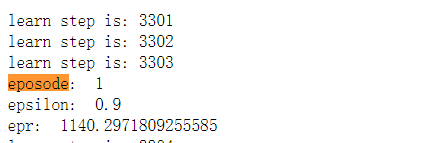

# 使用存储下来的priority模型权重进行测试:需要运行所有的class，如memory，Sumtree，还有DQN

In [10]:
RL_new = DeepQNetwork(n_actions=env.action_space.n,
                  n_features=env.observation_space.shape[0])

In [11]:
RL_new.eval_net.load_weights('priority_car_weights.h5')

In [12]:
totle_steps = 0

for episode in range(50):
    observation = env.reset()
    epr = 0
    while True:
        env.render()
        action = RL_new.choose_action(observation)
        observation_, reward, done, info = env.step(action) #还有一个叫做info

        if done:
            break
            
        observation = observation_
        totle_steps += 1
        


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



KeyboardInterrupt: 